# 🏴‍☠️ Pirate Pain Classification Challenge

> ⚓ *"Even pirates feel pain — let's teach the model to feel it too."*

---

## 📚 Table of Contents
0. [README](#readme)  
1. [Setup & Configuration](#setup)  
2. [Data Loading](#data-loading)  
3. [Import Libraries](#import-libraries)  
4. [Data Preprocessing](#data-preprocessing)  
5. [Sequence Building](#sequence-building)  
6. [DataLoaders](#dataloaders)  
7. [Network Hyperparameters](#hyperparameters)
8. [Model Architecture](#model-architecture)  
9. [Training Functions](#training-functions)  
10. [Model Training](#model-training)  
11. [Evaluation & Metrics](#evaluation)  
12. [Model Loading & Final Testing](#model-loading)  
13. [Competition Submission](#submission)

---

### ⚙️ Quick Configuration Map

> 🧭 *"If ye seek to tweak the code, here be where to look!"*

- 🧺 **Batch Size:** → [DataLoaders](#dataloaders)  
- ⚗️ **Hyperparameters:** → [Network Hyperparameters](#hyperparameters)  
- 🪞 **Window Size & Stride:** → [Sequence Building](#sequence-building)  
- ⚙️ **Model Type:** → [Setup & Configuration](#setup)  

---



---

### 💰 Treasure Storage — Models & Submissions
> 🏴‍☠️ *"A wise pirate always knows where his treasure be buried — guard yer models and submissions well!"*

- 💾 **Model & Submission Save/Load Path:** → [Setup & Configuration](#setup)  
  - 🗂️ Models be saved in a **`models/`** folder with the name:
    **`experiment_name_dd-mm-HH-MM.pt`** (day-month-hour-minute).
  - 📜 Submissions be saved in a **`submissions/`** folder with the filename format:  
    **`experiment_name_dd-mm-HH-MM.csv`** .
  - 🔡 All related model parameters are saved in **`models/`** folder with the  name **`experiment_name_dd-mm-HH-MM_config.json`** .

  
  *❗The experiment name is set as **`RnnType_Bi_dd-mm-HH-MM`** or **`RnnType_dd-mm-HH-MM`** depending on if it is bidirectional or not*
---






<a id="readme"></a>
## 0. Info



This section lists all the main parameters that can be modified to control data loading, model behavior, and training.

---

### 📁 File Paths
| Variable | Description | Default Value |
|-----------|--------------|----------------|
| `TRAIN_DATA_PATH` | Training features | `'pirate_pain_train.csv'` |
| `TRAIN_LABELS_PATH` | Training labels | `'pirate_pain_train_labels.csv'` |
| `TEST_DATA_PATH` | Test set for inference | `'pirate_pain_test.csv'` *(optional)* |
| `MODEL_SAVE_PATH` | Output model file | `'pirate_model.pt'` |
| `RESULTS_FILE` | CSV for predictions | `'results_<date-time>.csv'` |

---

### 🧠 Model & Architecture
| Parameter | Description | Typical Values |
|------------|--------------|----------------|
| `model_type` | Choose model class | `'RNN'`, `'LSTM'`, `'GRU'`, `'ANN'` |
| `input_size` | Number of features per time step | *auto-detected from data* |
| `hidden_size` | Hidden layer size | `64`, `128`, `256` |
| `num_layers` | Number of RNN layers | `1-4` |
| `dropout` | Dropout probability | `0.2–0.5` |
| `num_classes` | Output classes (pain levels) | *from label set* |

---

### 🏋️ Training Hyperparameters
| Parameter | Description | Default / Range |
|------------|--------------|-----------------|
| `batch_size` | Samples per batch | `512/2^n` |
| `learning_rate` | Optimizer learning rate | `1e-3` |
| `num_epochs` | Training iterations | `500` |
| `optimizer` | Optimization algorithm | `'AdamW'` |
| `criterion` | Loss function | `CrossEntropyLoss()` |
| `seed` | Random seed for reproducibility | `42` |

---

### 📤 Inference
| Parameter | Description |
|------------|--------------|
| `LOAD_MODEL_PATH` | Path to pretrained `.pt` model (optional) |
| `save_results` | Whether to write output CSV | `True` |

---

> 💡 *Tip:* Adjust hyperparameters in the “Configuration” or “Training Setup” cell before running the notebook.


<a id="setup"></a>
## 1. Setup & Configuration

*Optional: Connect to Google Drive (for Colab users)*

In [22]:
# from google.colab import drive
# drive.mount("/gdrive")
# current_dir = "/gdrive/My\\ Drive/[2025 - 2026]\\ AN2DL/Challenge 1/Personal Challenge 1"
# %cd $current_dir

*Set Model Type*

In [23]:
RNN_TYPE = 'LSTM'            # 'RNN', 'LSTM', or 'GRU'
BIDIRECTIONAL = True        # True / False

*Set Model Save Name*

In [24]:
from datetime import datetime

# Get current date and time for submission filename
current_datetime = datetime.now().strftime("%d-%m-%H-%M")

if BIDIRECTIONAL:
    EXPERIMENT_NAME = f"{RNN_TYPE}_bi_{current_datetime}"
else:
    EXPERIMENT_NAME = f"{RNN_TYPE}_{current_datetime}"

SUBMISSION_FILENAME = f"{EXPERIMENT_NAME}.csv"
print(f"Experiment name: {EXPERIMENT_NAME}")
print(f"Submission filename: {SUBMISSION_FILENAME}")

Experiment name: LSTM_bi_14-11-09-55
Submission filename: LSTM_bi_14-11-09-55.csv


<a id="data-loading"></a>
## 2. Data Loading

Load training and test datasets from CSV files.

In [25]:
import pandas as pd

X_train = pd.read_csv('an2dl2526c1/pirate_pain_train.csv')
y_train = pd.read_csv('an2dl2526c1/pirate_pain_train_labels.csv')

<a id="import-libraries"></a>
## 3. Import Libraries

Set random seeds for reproducibility and import all necessary packages.

In [26]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Directory configuration
logs_dir = "tensorboard"
models_dir = "models"



# Model save/load paths
MODEL_SAVE_PATH = f"{models_dir}/{EXPERIMENT_NAME}_model.pt"
MODEL_LOAD_PATH = f"{models_dir}/{EXPERIMENT_NAME}_model.pt"

!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p {models_dir}

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.10.0.dev20251109+cu128
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


In [27]:
# Import missing scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

print("✅ ReduceLROnPlateau imported successfully!")

✅ ReduceLROnPlateau imported successfully!


In [28]:
# ✅ ISSUE RESOLVED: ReduceLROnPlateau Import Fixed
print("🔧 ISSUE RESOLUTION SUMMARY")
print("="*50)
print("❌ Previous Error: NameError: name 'ReduceLROnPlateau' is not defined")
print("✅ Solution: Added missing import: from torch.optim.lr_scheduler import ReduceLROnPlateau")
print("🎯 Status: Ready to use ReduceLROnPlateau in model training")

# Test that the import works
try:
    # Create a dummy model and optimizer to test ReduceLROnPlateau
    test_model = nn.Linear(10, 1)
    test_optimizer = torch.optim.Adam(test_model.parameters())
    test_scheduler = ReduceLROnPlateau(test_optimizer, mode='max', factor=0.8, patience=5)
    print("✅ ReduceLROnPlateau test successful - import working correctly!")
    del test_model, test_optimizer, test_scheduler  # Clean up test objects
except Exception as e:
    print(f"❌ ReduceLROnPlateau test failed: {e}")

print("\n🚀 You can now run your Conv-Enhanced model training without errors!")

🔧 ISSUE RESOLUTION SUMMARY
❌ Previous Error: NameError: name 'ReduceLROnPlateau' is not defined
✅ Solution: Added missing import: from torch.optim.lr_scheduler import ReduceLROnPlateau
🎯 Status: Ready to use ReduceLROnPlateau in model training
✅ ReduceLROnPlateau test successful - import working correctly!

🚀 You can now run your Conv-Enhanced model training without errors!


<a id="data-preprocessing"></a>
## 4. Data Preprocessing

Explore data, split into train/val/test sets, normalize features, and encode labels.

In [29]:
# Print the shape of the dataset
print(f"Dataset shape: {X_train.shape}")

# Display the first few rows of the dataset
X_train.head(10)

Dataset shape: (105760, 40)


Dataset shape: (105760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.073167e-06,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.074800e-06,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5
7,0,7,2,2,2,2,two,two,two,1.038597,...,8.829074e-07,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.621055e-06,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5
9,0,9,0,2,2,2,two,two,two,1.054999,...,1.609114e-06,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5


### 4.1 Data Exploration

In [30]:
from sklearn.preprocessing import LabelEncoder

# Merge features and labels
data = X_train.merge(y_train, on='sample_index')

# Create a mapping dictionary to convert categorical labels to numerical values
# map_dict = {'none': 0, 'one': 1, 'two': 2}
# data['n_legs'] = data['n_legs'].map(map_dict)
# data['n_hands'] = data['n_hands'].map(map_dict)
# data['n_eyes'] = data['n_eyes'].map(map_dict)

# print("Loading test dataset for final evaluation...")

cols = ['n_legs', 'n_hands', 'n_eyes']
unique_values = {col: X_train[col].unique().tolist() for col in cols}

unique_values

{'n_legs': ['two', 'one+peg_leg'],
 'n_hands': ['two', 'one+hook_hand'],
 'n_eyes': ['two', 'one+eye_patch']}

In [31]:
map_dict = {'two': 2, 'one+peg_leg': 1}
data['n_legs'] = data['n_legs'].map(map_dict)

map_dict = {'two': 2, 'one+hook_hand': 1}
data['n_hands'] = data['n_hands'].map(map_dict)

map_dict = {'two': 2, 'one+eye_patch': 1}
data['n_eyes'] = data['n_eyes'].map(map_dict)

print("Mapped string columns to numeric values!")
print(data.head())

Mapped string columns to numeric values!
   sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              0              2   
1             0     1              2              2              2   
2             0     2              2              0              2   
3             0     3              2              2              2   
4             0     4              2              2              2   

   pain_survey_4  n_legs  n_hands  n_eyes  joint_00  ...      joint_22  \
0              1       2        2       2  1.094705  ...  1.945042e-06   
1              2       2        2       2  1.135183  ...  6.765107e-07   
2              2       2        2       2  1.080745  ...  1.698525e-07   
3              2       2        2       2  0.938017  ...  5.511079e-07   
4              2       2        2       2  1.090185  ...  1.735459e-07   

   joint_23      joint_24  joint_25  joint_26  joint_27  joint_28  joint_29  \
0  0.000004  1

In [32]:
data.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.0
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,1.990923,1.990923,1.990923,0.943095,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.5
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.094841,0.094841,0.094841,0.202051,...,4.974496e-03,5.472244e-03,1.235450e-03,4.062914e-04,3.206128e-03,0.060293,0.079819,0.060773,0.072597,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.5
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.828277,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.5
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.005126,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746147e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.5
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.081039,...,2.800090e-06,3.079465e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.5
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.407968,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,0.5


In [33]:
list_to_remove = ['n_legs', 'n_hands', 'n_eyes', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_30']

if data.columns.isin(list_to_remove).any():
  data = data.drop(columns=['n_legs', 'n_hands', 'n_eyes', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_30'])
  data.head()
else:
  print("Usless features already removed")

In [34]:
# Count the continouse and categorical features

continuous_cols = [col for col in data.columns if col.startswith('joint_')]
categorical_cols = [col for col in data.columns if col.startswith('pain_survey_')]

print(f"Continuous features: {len(continuous_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

Continuous features: 17
Categorical features: 4


In [35]:
# Check what columns remain after removal
print("Columns after removal:")
print(data.columns.tolist())
print(f"\nNumber of features remaining: {len(data.columns)}")

# Identify categorical features (int64 pain_survey columns)
categorical_features = []
for col in data.columns:
    if 'pain_survey' in col and data[col].dtype == 'int64':
        categorical_features.append(col)

print(f"\nCategorical features identified: {categorical_features}")

# Check the remaining joint features
joint_features = [col for col in data.columns if col.startswith('joint_')]
print(f"Remaining joint features: {joint_features}")
print(f"Number of joint features: {len(joint_features)}")

Columns after removal:
['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'label']

Number of features remaining: 24

Categorical features identified: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
Remaining joint features: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
Number of joint features: 17


In [36]:
# Define embedding dimensions for categorical features
# For 3 unique values (0, 1, 2), embedding dimension of 2 is reasonable
embedding_dims = {
    'pain_survey_1': 2,
    'pain_survey_2': 2,
    'pain_survey_3': 2,
    'pain_survey_4': 2
}

print(f"Embedding dimensions: {embedding_dims}")
print(f"Total embedding output size: {sum(embedding_dims.values())}")
print(f"Continuous features (joints): {len(joint_features)}")
print(f"Total input size to LSTM: {sum(embedding_dims.values()) + len(joint_features)}")

Embedding dimensions: {'pain_survey_1': 2, 'pain_survey_2': 2, 'pain_survey_3': 2, 'pain_survey_4': 2}
Total embedding output size: 8
Continuous features (joints): 17
Total input size to LSTM: 25


In [37]:
data.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29,label
0,0,0,2,0,2,1,1.094705,0.985281,1.018302,1.010385,...,0.712989,1.050142,0.529555,0.447370,1.091046,0.017592,0.013508,0.026798,0.027815,no_pain
1,0,1,2,2,2,2,1.135183,1.021175,0.994343,1.052364,...,0.722685,1.060313,0.446810,0.414432,1.045862,0.013352,0.000000,0.013377,0.013716,no_pain
2,0,2,2,0,2,2,1.080745,0.962842,1.009588,0.977169,...,0.668043,1.011410,0.432499,0.431535,1.088221,0.016225,0.008110,0.024097,0.023105,no_pain
3,0,3,2,2,2,2,0.938017,1.081592,0.998021,0.987283,...,0.702085,1.047223,0.478806,0.420665,1.096832,0.011832,0.007450,0.028613,0.024648,no_pain
4,0,4,2,2,2,2,1.090185,1.032145,1.008710,0.963658,...,0.712197,1.044731,0.452906,0.476537,1.103968,0.005360,0.002532,0.033026,0.025328,no_pain


In [38]:
# Check the columns and their types
print("Columns in data:")
print(data.columns.tolist())
print("\nData types:")
print(data.dtypes)

# Check for categorical features (pain_survey columns)
pain_survey_cols = [col for col in data.columns if 'pain_survey' in col]
print(f"\nPain survey columns: {pain_survey_cols}")

# Check unique values in pain_survey columns
for col in pain_survey_cols:
    print(f"\nUnique values in {col}:")
    print(data[col].unique())
    print(f"Number of unique values: {data[col].nunique()}")

Columns in data:
['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'label']

Data types:
sample_index       int64
time               int64
pain_survey_1      int64
pain_survey_2      int64
pain_survey_3      int64
pain_survey_4      int64
joint_00         float64
joint_01         float64
joint_02         float64
joint_03         float64
joint_04         float64
joint_05         float64
joint_06         float64
joint_07         float64
joint_08         float64
joint_09         float64
joint_10         float64
joint_11         float64
joint_12         float64
joint_26         float64
joint_27         float64
joint_28         float64
joint_29         float64
label             object
dtype: object

Pain survey columns: ['pain_survey_1', 'pain_surv

## Preprocessing testing dataset

In [39]:
# Load the actual test dataset (this doesn't have labels)
X_test_final_df = pd.read_csv('an2dl2526c1/pirate_pain_test.csv')

# Map string columns to numeric values first
map_dict = {'two': 2, 'one+peg_leg': 1}
X_test_final_df['n_legs'] = X_test_final_df['n_legs'].map(map_dict)

map_dict = {'two': 2, 'one+hook_hand': 1}
X_test_final_df['n_hands'] = X_test_final_df['n_hands'].map(map_dict)

map_dict = {'two': 2, 'one+eye_patch': 1}
X_test_final_df['n_eyes'] = X_test_final_df['n_eyes'].map(map_dict)

print("Mapped string columns to numeric values!")
print(X_test_final_df.head())

# Now convert inputs from float64 to float32
X_test_final_df = X_test_final_df.astype(np.float32)

Mapped string columns to numeric values!
   sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              2              2   
1             0     1              2              2              2   
2             0     2              2              2              2   
3             0     3              1              2              2   
4             0     4              2              2              2   

   pain_survey_4  n_legs  n_hands  n_eyes  joint_00  ...  joint_21  joint_22  \
0              2       2        2       2  0.842535  ...  0.000003  0.000004   
1              2       2        2       2  0.898836  ...  0.000003  0.000004   
2              2       2        2       2  0.957765  ...  0.000006  0.000004   
3              2       2        2       2  0.832596  ...  0.000005  0.000004   
4              0       2        2       2  0.805971  ...  0.000006  0.000004   

   joint_23  joint_24  joint_25  joint_26  joint_27  join

In [40]:
def build_sequences_test(df, window=200, stride=200):
    assert window % stride == 0

    dataset = []

    # Get feature columns (exclude sample_index and time)
    columns = [col for col in df.columns if col not in ['sample_index', 'time']]

    for id in df['sample_index'].unique():
        temp = df[df['sample_index'] == id][columns].values

        # Padding
        padding_len = (window - len(temp) % window) % window
        padding = np.zeros((padding_len, len(columns)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build windows
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            idx += stride

    return np.array(dataset)

In [41]:
# ------ Normalize test data ------

list_to_remove = ['n_legs', 'n_hands', 'n_eyes', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_30']

if X_test_final_df.columns.isin(list_to_remove).any():
    X_test_final_df = X_test_final_df.drop(columns=['n_legs', 'n_hands', 'n_eyes', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_30'])
else:
  print("Usless features already removed")

# --- Load and preprocess the actual test dataset ---
# Define the columns to be normalised (use training statistics for proper normalization)
# Exclude 'sample_index', 'time', and 'label' as they were excluded during training sequence building
# Also exclude 'joint_30' as it was removed from training data
scale_columns = [col for col in X_test_final_df.columns
                 if col != 'sample_index' and col != 'time' and col != 'joint_30']

# Calculate the minimum and maximum values from the training data only
mins_train = X_test_final_df[scale_columns].min()
maxs_train = X_test_final_df[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the testing set
    if maxs_train[column] != mins_train[column]:
      X_test_final_df[column] = (X_test_final_df[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])

X_test_final_df.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
0,0.0,0.0,1.0,1.0,1.0,1.0,0.561563,0.553352,0.419037,0.270175,...,0.654303,0.737832,0.742275,0.100076,0.146564,0.745300,0.014909,0.045098,0.012882,0.010178
1,0.0,1.0,1.0,1.0,1.0,1.0,0.599088,0.532067,0.461325,0.327922,...,0.684443,0.772454,0.710705,0.103457,0.174403,0.594262,0.053679,0.055375,0.013892,0.029085
2,0.0,2.0,1.0,1.0,1.0,1.0,0.638365,0.583960,0.445804,0.308796,...,0.676488,0.799646,0.722061,0.143175,0.159973,0.652024,0.042305,0.039620,0.016286,0.040638
3,0.0,3.0,0.5,1.0,1.0,1.0,0.554938,0.488719,0.443494,0.355023,...,0.650563,0.738087,0.709363,0.141007,0.167449,0.709558,0.037477,0.031101,0.008568,0.018730
4,0.0,4.0,1.0,1.0,1.0,0.0,0.537192,0.528780,0.413159,0.363199,...,0.653239,0.703021,0.681513,0.140234,0.186249,0.590142,0.015210,0.019426,0.008189,0.013444


### 4.2 Categorical Encoding

In [42]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split

# df has columns: ['sample_index', 'label']
N_NO_PAIN_KEEP = 1000   # how many "no_pain" pirates to keep in the training set (lower it to have a more balanced distribution of the labels)
N_LOW_PAIN_KEEP = 150   # how many "low_pain" pirates to keep in the training set
N_VAL_USERS = 160
N_TEST_USERS = 3

# --- Step 1: Compute each user's dominant label (or label distribution)
user_labels = (
    data.groupby('sample_index')['label']
    .agg(lambda x: x.value_counts().index[0])  # dominant label per user
    .reset_index()
)

print("Original label distribution:", user_labels['label'].value_counts().to_dict())

# --- Step 2: Split into train/val/test keeping real label proportions
train_users, temp_users = train_test_split(
    user_labels['sample_index'],
    test_size=(N_VAL_USERS + N_TEST_USERS) / len(user_labels),
    stratify=user_labels['label'],
    random_state=None
)

# Split temp into val/test (also stratified)
temp_labels = user_labels[user_labels['sample_index'].isin(temp_users)]

val_users, test_users = train_test_split(
    temp_labels['sample_index'],
    test_size=N_TEST_USERS / (N_VAL_USERS + N_TEST_USERS),
    stratify=temp_labels['label'],
    random_state=None
)




# === Step 3: Create a partially balanced training set keeping a fixed number of pirates per label ===
train_labels = user_labels[user_labels['sample_index'].isin(train_users)]

# Count of how many pirates are present for each label in training set
label_counts = train_labels['label'].value_counts()
print("Train label counts before balancing:", label_counts.to_dict())

# --- Custom undersampling logic ---
rng = random.Random()

no_pain_users = train_labels[train_labels['label'] == 'no_pain']['sample_index'].tolist()
low_pain_users = train_labels[train_labels['label'] == 'low_pain']['sample_index'].tolist()
high_pain_users = train_labels[train_labels['label'] == 'high_pain']['sample_index'].tolist()

# Choose how many to keep for each label
no_pain_keep = min(N_NO_PAIN_KEEP, len(no_pain_users))
low_pain_keep = min(N_LOW_PAIN_KEEP, len(low_pain_users))
high_pain_keep = len(high_pain_users)  # keep all high_pain pirates

selected_no_pain = rng.sample(no_pain_users, no_pain_keep)
selected_low_pain = rng.sample(low_pain_users, low_pain_keep)
selected_high_pain = high_pain_users  # keep all

# Combine the selected users
selected_users = selected_no_pain + selected_low_pain + selected_high_pain
balanced_train_labels = train_labels[train_labels['sample_index'].isin(selected_users)]

print("Train label counts after balancing:", balanced_train_labels['label'].value_counts().to_dict())

train_users = balanced_train_labels['sample_index']

# Compute validation and test label distributions
val_label_counts = user_labels[user_labels['sample_index'].isin(val_users)]['label'].value_counts().to_dict()
test_label_counts = user_labels[user_labels['sample_index'].isin(test_users)]['label'].value_counts().to_dict()
print("Validation and Test distributions:")
print("Validation label counts:", val_label_counts)
print("Test label counts:", test_label_counts)


# --- Step 4: Filter your main df
df_train = data[data['sample_index'].isin(train_users)]
df_val = data[data['sample_index'].isin(val_users)]
df_test = data[data['sample_index'].isin(test_users)]

# --- Step 5: Check label proportions
print("Label proportions:")
print("Train:\n", df_train['label'].value_counts(normalize=True))
print("Val:\n", df_val['label'].value_counts(normalize=True))
print("Test:\n", df_test['label'].value_counts(normalize=True))

Original label distribution: {'no_pain': 511, 'low_pain': 94, 'high_pain': 56}
Train label counts before balancing: {'no_pain': 385, 'low_pain': 71, 'high_pain': 42}
Train label counts after balancing: {'no_pain': 385, 'low_pain': 71, 'high_pain': 42}
Validation and Test distributions:
Validation label counts: {'no_pain': 124, 'low_pain': 22, 'high_pain': 14}
Test label counts: {'no_pain': 2, 'low_pain': 1}
Label proportions:
Train:
 label
no_pain      0.773092
low_pain     0.142570
high_pain    0.084337
Name: proportion, dtype: float64
Val:
 label
no_pain      0.7750
low_pain     0.1375
high_pain    0.0875
Name: proportion, dtype: float64
Test:
 label
no_pain     0.666667
low_pain    0.333333
Name: proportion, dtype: float64


### 4.3 Stratified Train/Val/Test Split

In [43]:
df_train.shape, df_val.shape, df_test.shape

((79680, 24), (25600, 24), (480, 24))

In [44]:
# Print the total number of pirates for each dataset
print(f"Total pirates in training set: {df_train['sample_index'].nunique()}")
print(f"Total pirates in validation set: {df_val['sample_index'].nunique()}")
print(f"Total pirates in test set: {df_test['sample_index'].nunique()}")

Total pirates in training set: 498
Total pirates in validation set: 160
Total pirates in test set: 3


In [45]:
df_train

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29,label
0,0,0,2,0,2,1,1.094705,0.985281,1.018302,1.010385,...,0.712989,1.050142,0.529555,0.447370,1.091046,0.017592,0.013508,0.026798,0.027815,no_pain
1,0,1,2,2,2,2,1.135183,1.021175,0.994343,1.052364,...,0.722685,1.060313,0.446810,0.414432,1.045862,0.013352,0.000000,0.013377,0.013716,no_pain
2,0,2,2,0,2,2,1.080745,0.962842,1.009588,0.977169,...,0.668043,1.011410,0.432499,0.431535,1.088221,0.016225,0.008110,0.024097,0.023105,no_pain
3,0,3,2,2,2,2,0.938017,1.081592,0.998021,0.987283,...,0.702085,1.047223,0.478806,0.420665,1.096832,0.011832,0.007450,0.028613,0.024648,no_pain
4,0,4,2,2,2,2,1.090185,1.032145,1.008710,0.963658,...,0.712197,1.044731,0.452906,0.476537,1.103968,0.005360,0.002532,0.033026,0.025328,no_pain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105755,660,155,2,2,0,0,1.051738,0.906653,0.852813,0.714132,...,0.793007,0.818443,0.696164,0.676377,1.065835,0.007856,0.026876,0.173566,0.221921,no_pain
105756,660,156,2,2,0,2,1.027651,0.894214,0.834575,0.790003,...,0.742828,0.861304,0.642332,0.677491,1.021720,0.026795,0.012778,0.075945,0.116763,no_pain
105757,660,157,0,2,2,2,1.113381,0.803824,0.856149,0.659963,...,0.781024,0.872811,0.723307,0.751857,1.031213,0.036982,0.028014,0.075978,0.078339,no_pain
105758,660,158,2,2,2,2,1.058100,0.902272,0.787495,0.685756,...,0.759178,0.790487,0.702029,0.678239,1.045568,0.046405,0.017922,0.097109,0.106807,no_pain


In [46]:
scale_columns = [col for col in data.columns
                 if col != 'sample_index' and col != 'joint_30' and col != 'label']

# Calculate the minimum and maximum values from the training data only
mins_train = df_train[scale_columns].min()
maxs_train = df_train[scale_columns].max()

mins_val = df_val[scale_columns].min()
maxs_val = df_val[scale_columns].max()

mins_test = df_test[scale_columns].min()
maxs_test = df_test[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    if maxs_train[column] != mins_train[column] and mins_val[column] != maxs_val[column] and mins_test[column] != maxs_test[column]:
      df_train[column] = (df_train[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])

      # Normalise the validation set
      df_val[column] = (df_val[column] - mins_val[column]) / (maxs_val[column] - mins_val[column])

      # Normalise the test set
      df_test[column] = (df_test[column] - mins_test[column]) / (maxs_test[column] - mins_test[column])

    # elif column == 'n_hands' or column == 'n_eyes' or column == 'n_legs':
    #   df_train[column] = 0.5
    #   df_val[column] = 0.5
    #   df_test[column] = 0.5


In [47]:
df_train

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29,label
0,0,0.000000,1.0,0.0,1.0,0.5,0.777046,0.738252,0.779512,0.804419,...,0.478382,0.753815,0.272106,0.269510,0.762947,0.014214,0.011376,0.018978,0.020291,no_pain
1,0,0.006289,1.0,1.0,1.0,1.0,0.805855,0.765147,0.761153,0.838021,...,0.486231,0.761224,0.217448,0.245846,0.727910,0.010748,0.000000,0.009473,0.010006,no_pain
2,0,0.012579,1.0,0.0,1.0,1.0,0.767110,0.721439,0.772834,0.777832,...,0.441994,0.725601,0.207995,0.258133,0.760757,0.013097,0.006830,0.017065,0.016856,no_pain
3,0,0.018868,1.0,1.0,1.0,1.0,0.665528,0.810416,0.763971,0.785928,...,0.469554,0.751688,0.238584,0.250324,0.767434,0.009505,0.006274,0.020264,0.017981,no_pain
4,0,0.025157,1.0,1.0,1.0,1.0,0.773829,0.773366,0.772162,0.767017,...,0.477740,0.749873,0.221475,0.290464,0.772967,0.004216,0.002132,0.023389,0.018477,no_pain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105755,660,0.974843,1.0,1.0,0.0,0.0,0.746465,0.679338,0.652703,0.567290,...,0.543164,0.585036,0.382161,0.434035,0.743398,0.006255,0.022634,0.122919,0.161896,no_pain
105756,660,0.981132,1.0,1.0,0.0,1.0,0.729322,0.670018,0.638728,0.628019,...,0.502539,0.616258,0.346602,0.434835,0.709191,0.021736,0.010761,0.053784,0.085181,no_pain
105757,660,0.987421,0.0,1.0,1.0,1.0,0.790338,0.602290,0.655260,0.523931,...,0.533463,0.624639,0.400091,0.488262,0.716552,0.030063,0.023592,0.053808,0.057150,no_pain
105758,660,0.993711,1.0,1.0,1.0,1.0,0.750993,0.676055,0.602652,0.544576,...,0.515776,0.564671,0.386035,0.435373,0.727682,0.037765,0.015093,0.068772,0.077918,no_pain


In [48]:
# Define a function to inspect sensor data for a specific label
def inspect_label(label, df):
    # Filter the DataFrame for the specified label and limit to 159 rows
    data = df[df['label'] == label][['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']][:159]

    # Plot the sensor data for each axis
    axis = data.plot(subplots=True, figsize=(17, 9), title=label)

    # Adjust legend position for each subplot
    for ax in axis:
        ax.legend(loc='lower right')

In [49]:
# Define a function to inspect sensor data for a specific label
def inspect_label(label, df):
    # Filter the DataFrame for the specified label and limit to 159 rows
    data = df[df['label'] == label][['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05' , 'joint_06', 'joint_07' , 'joint_08', 'joint_09' , 'joint_10', 'joint_11' , 'joint_12']][:159]

    # Plot the sensor data for each axis
    axis = data.plot(subplots=True, figsize=(17, 9), title=label)

    # Adjust legend position for each subplot
    for ax in axis:
        ax.legend(loc='lower right')

### 4.4 Feature Normalization

In [50]:
# Initialise a dictionary to count occurrences of each activity in the training set
training_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_train['sample_index'].unique():
    label = df_train[df_train['sample_index'] == id]['label'].values[0]
    training_labels[label] += 1


#if 'joint_30' in df_train.columns:
#    df_train = df_train.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of training labels
print('Training labels:', training_labels)

# Initialise a dictionary to count occurrences of each activity in the training set
val_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_val['sample_index'].unique():
    label = df_val[df_val['sample_index'] == id]['label'].values[0]
    val_labels[label] += 1


#if 'joint_30' in df_val.columns:
#    df_val = df_val.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of validation labels
print('Validation labels:', val_labels)

# Initialise a dictionary to count occurrences of each activity in the test set
test_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the test set
for id in df_test['sample_index'].unique():
    label = df_test[df_test['sample_index'] == id]['label'].values[0]
    test_labels[label] += 1
#if 'joint_30' in df_test.columns:
#    df_test = df_test.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of test labels
print('Test labels:', test_labels)

Training labels: {'no_pain': 385, 'low_pain': 71, 'high_pain': 42}
Validation labels: {'no_pain': 124, 'low_pain': 22, 'high_pain': 14}
Test labels: {'no_pain': 2, 'low_pain': 1, 'high_pain': 0}


### 4.5 Label Distribution Analysis

In [51]:
# Define a training mapping of label names to integer labels
train_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the training set
df_train['label'] = df_train['label'].map(train_label_mapping)

# Define a validation mapping of label names to integer labels
val_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the validation set
df_val['label'] = df_val['label'].map(val_label_mapping)

test_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the test set
df_test['label'] = df_test['label'].map(test_label_mapping)


<a id="sequence-building"></a>
## 5. Sequence Building

Convert variable-length time-series into fixed-size windows for RNN input.

In [52]:

# Define window and stride boolean variable -> if True, during training we will visit more time the same pirate with overlapping windows
# if False, each pirate will be visited only once during training
one_pirate_window = True

In [53]:
if one_pirate_window:
    # Define the window size
    WINDOW_SIZE = 10      #68 

    # Stride size
    STRIDE = 5           #17
else:
    # Define the window size -> select an higher window size in order to get more pirates
    WINDOW_SIZE = 160

    # Stride size
    STRIDE = 160

### 5.1 Window & Stride Configuration

In [54]:
"""
  GENERAL COMMENTS:
  in this function we are restricting for each user data the number of samples of recorded data to a constant
  value (window size), since every user data could be composed by different numbers of timestep. Therefore we are
  "normalizing" the timesteps of a constant window size. Additionally is also defined a stride variable, which if is equal to
  the window size, then we are not taking overlapping timestamp samples, instead if stride < window, we are letting some samples
  to overlap in such a way that the RNN or other kind of NN architecture will analyze better the context.
"""

# Define a function to build sequences from the dataset
def build_sequences(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0 # checks if the window size is divisible by the stride

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():

        # Extract pirate sample index data for the current sample index
        columns = [col for col in df.columns if col not in ['sample_index', 'label', 'time']]

        temp = df[df['sample_index'] == id][columns].values

        # Retrieve the label for the current pirate
        label = df[df['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(columns)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

### 5.2 Build Sequences Function

In [55]:
# Generate sequences and labels for the training set
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the test set
X_test, y_test = build_sequences(df_test, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((16434, 10, 21), (16434,), (5280, 10, 21), (5280,), (99, 10, 21), (99,))

### 5.3 Generate Sequences for Train/Val/Test

In [56]:
# Convert dataset into float32 for PyTorch compatibility
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

### 5.4 Data Type Conversion & Cleaning

In [57]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [58]:
# Discard nan values from the dataset
if np.isnan(X_train).any() or np.isnan(X_val).any() or np.isnan(X_test).any():
    X_train = np.nan_to_num(X_train)
    X_val = np.nan_to_num(X_val)
    X_test = np.nan_to_num(X_test)


In [59]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

<a id="dataloaders"></a>
## 6. DataLoaders

Create PyTorch DataLoaders for efficient batching and parallel loading.

In [60]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 480   # before: 512 

In [61]:
def make_loader(ds, batch_size, shuffle, drop_last, sampler=None):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle if sampler is None else False,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
        sampler=sampler
    )

In [62]:
from torch.utils.data import WeightedRandomSampler

# Compute class counts
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(weights=torch.tensor(sample_weights, dtype=torch.float32), num_samples=len(sample_weights), replacement=True)

# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, sampler=sampler)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [63]:
from collections import Counter

batch_labels = []
for _, yb in train_loader:
    batch_labels.extend(yb.tolist())
    if len(batch_labels) > 5000:  # just check some batches
        break

print("Simulated batch distribution:", Counter(batch_labels))

Simulated batch distribution: Counter({1: 1789, 0: 1759, 2: 1732})


In [64]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([480, 10, 21])
Labels batch shape: torch.Size([480])


In [65]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

<a id="hyperparameters"></a>
## 7. Network Hyperparameters

Configure training settings, architecture parameters, and regularization.

In [66]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 42  # Neurons per layer -> prev hidden size = 128

# Regularisation
DROPOUT_RATE = 0.30      # Dropout probability

# For now disable weight decay
L1_LAMBDA = 1e-6        # L1 penalty
L2_LAMBDA = 1e-4          # L2 penalty

NUM_CLASS = 3           # Number of output classes 

# Set up loss function and optimizer

# TO GIVE DIFFERENT WEIGHTS TO THE LOSS DEPENDING ON THE INVERSE OF EACH LABEL TOTAL NUMBER:
# Set up loss function and optimizer
# from sklearn.utils.class_weight import compute_class_weight
# classes = np.unique(y_train)
# class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# print(f"Class weights (order = {classes}): {class_weights.cpu().numpy()}")


# TO GIVE FIXED WEIGHTS TO THE LOSS FUNCTION DEPENDING ON THE LABELS DISTRIBUTION:
# weights = torch.tensor([1.0, 1.2, 1.4]).to(device)
# criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()


# TO NOT CHANGE THE WEIGHTS, BUT WITH LABEL SMOOTHING
# alpha = torch.tensor([0.5, 1.5, 2.0])
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


# TO WEIGHT MORE THE "MORE DIFFICULT" CASES AND THE LESS FREQUENT LABELS:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=alpha, reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()
alpha = None
# alpha = torch.tensor([0.7, 1.3, 1.7], dtype=torch.float32, device=device)  # None if we don't want to alterate the weights of each label losses (FocalLoss already do it)
criterion = FocalLoss(alpha=alpha, gamma=2.3)  # gamma = 0 it's like Crossentropy(), gamma < 1 it's like in between Crossentropy and FocalLoss,
                                               # gamma = 1 it's a good compromise, gamma = 1.5 or gamma = 2 to weight so much the less present labels

In [67]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

<a id="model-architecture"></a>
## 8. Model Architecture

Custom RNN/LSTM/GRU classifier with configurable bidirectionality and dropout.

### Enhanced LSTM Model with Embedding Layers

This enhanced model uses embedding layers for the categorical `pain_survey` features before feeding them to the LSTM.

In [68]:
class EnhancedRecurrentClassifier(nn.Module):
    """
    Enhanced RNN classifier with embedding layers for categorical features.
    Combines embeddings with continuous features before passing to LSTM.
    """
    def __init__(
            self,
            continuous_input_size,    # Number of continuous features (joints)
            categorical_features,     # Dict: {feature_name: num_unique_values}
            embedding_dims,          # Dict: {feature_name: embedding_dimension}
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='LSTM',
            bidirectional=True,
            dropout_rate=0.2
            ):
        super().__init__()
        
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.categorical_features = list(categorical_features.keys())
        self.continuous_input_size = continuous_input_size
        
        # Create embedding layers for each categorical feature
        self.embeddings = nn.ModuleDict()
        total_embedding_size = 0
        
        for feature, num_values in categorical_features.items():
            embed_dim = embedding_dims[feature]
            # Add 1 to num_values to handle potential out-of-range values
            self.embeddings[feature] = nn.Embedding(num_values + 1, embed_dim)
            total_embedding_size += embed_dim
            print(f"Created embedding for {feature}: {num_values} -> {embed_dim}")
        
        # Total input size to RNN = continuous features + all embedding outputs
        rnn_input_size = continuous_input_size + total_embedding_size
        print(f"Total RNN input size: {continuous_input_size} (continuous) + {total_embedding_size} (embeddings) = {rnn_input_size}")
        
        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }
        
        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")
        
        rnn_module = rnn_map[rnn_type]
        
        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0
        
        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )
        
        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2
        else:
            classifier_input_size = hidden_size
        
        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, categorical_indices):
        """
        x: (batch_size, seq_length, continuous_features)
        categorical_indices: Dict of {feature_name: (batch_size, seq_length)} tensors
        """
        batch_size, seq_length, _ = x.shape
        
        # Process embeddings for each categorical feature
        embedded_features = []
        
        for feature_name in self.categorical_features:
            if feature_name in categorical_indices:
                # Get the categorical indices for this feature
                cat_indices = categorical_indices[feature_name]  # (batch_size, seq_length)
                
                # Apply embedding
                embedded = self.embeddings[feature_name](cat_indices)  # (batch_size, seq_length, embed_dim)
                embedded_features.append(embedded)
        
        # Concatenate all embeddings with continuous features
        if embedded_features:
            all_embeddings = torch.cat(embedded_features, dim=-1)  # (batch_size, seq_length, total_embed_dim)
            combined_input = torch.cat([x, all_embeddings], dim=-1)  # (batch_size, seq_length, total_input_size)
        else:
            combined_input = x
        
        # Pass through RNN
        rnn_out, hidden = self.rnn(combined_input)
        
        # Use the last hidden state for classification
        if self.rnn_type in ['LSTM', 'GRU']:
            if isinstance(hidden, tuple):  # LSTM returns (h_n, c_n)
                last_hidden = hidden[0]
            else:  # GRU returns h_n
                last_hidden = hidden
        else:  # RNN
            last_hidden = hidden
        
        # Get the last hidden state from the last layer
        if self.bidirectional:
            # Concatenate forward and backward directions
            last_hidden = torch.cat([last_hidden[-2], last_hidden[-1]], dim=1)
        else:
            last_hidden = last_hidden[-1]
        
        # Apply dropout and classification
        output = self.dropout(last_hidden)
        output = self.classifier(output)
        
        return output

In [69]:
def build_sequences_enhanced(df, window=200, stride=200, categorical_features=['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']):
    """
    Enhanced version of build_sequences that separates categorical and continuous features.
    
    Returns:
    - continuous_data: numpy array of continuous features
    - categorical_data: dict of categorical features
    - labels: numpy array of labels
    """
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0
    
    # Separate categorical and continuous features
    exclude_cols = ['sample_index', 'label', 'time'] + categorical_features
    continuous_cols = [col for col in df.columns if col not in exclude_cols]
    
    print(f"Categorical features: {categorical_features}")
    print(f"Continuous features: {continuous_cols}")
    print(f"Number of continuous features: {len(continuous_cols)}")
    
    # Initialize lists to store sequences and their corresponding labels
    continuous_dataset = []
    categorical_datasets = {feature: [] for feature in categorical_features}
    labels = []
    
    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract data for the current sample index
        pirate_data = df[df['sample_index'] == id]
        
        # Extract continuous features
        continuous_temp = pirate_data[continuous_cols].values
        
        # Extract categorical features
        categorical_temps = {}
        for feature in categorical_features:
            categorical_temps[feature] = pirate_data[feature].values
        
        # Retrieve the label for the current pirate
        label = pirate_data['label'].values[0]
        
        # Calculate padding length to ensure full windows
        padding_len = window - len(continuous_temp) % window
        
        # Create zero padding for continuous features
        continuous_padding = np.zeros((padding_len, len(continuous_cols)), dtype='float32')
        continuous_temp = np.concatenate((continuous_temp, continuous_padding))
        
        # Create padding for categorical features (use 0 as padding)
        for feature in categorical_features:
            categorical_padding = np.zeros(padding_len, dtype='int64')
            categorical_temps[feature] = np.concatenate((categorical_temps[feature], categorical_padding))
        
        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(continuous_temp):
            # Continuous features
            continuous_dataset.append(continuous_temp[idx:idx + window])
            
            # Categorical features
            for feature in categorical_features:
                categorical_datasets[feature].append(categorical_temps[feature][idx:idx + window])
            
            labels.append(label)
            idx += stride
    
    # Convert lists to numpy arrays for further processing
    continuous_dataset = np.array(continuous_dataset, dtype='float32')
    for feature in categorical_features:
        categorical_datasets[feature] = np.array(categorical_datasets[feature], dtype='int64')
    labels = np.array(labels)
    
    print(f"Continuous data shape: {continuous_dataset.shape}")
    for feature in categorical_features:
        print(f"{feature} shape: {categorical_datasets[feature].shape}")
    print(f"Labels shape: {labels.shape}")
    
    return continuous_dataset, categorical_datasets, labels

In [70]:
# Generate enhanced sequences for training, validation, and test sets
print("=== Building Enhanced Sequences ===")

# Build sequences with separated categorical and continuous features
X_train_cont, X_train_cat, y_train_enh = build_sequences_enhanced(df_train, WINDOW_SIZE, STRIDE)
X_val_cont, X_val_cat, y_val_enh = build_sequences_enhanced(df_val, WINDOW_SIZE, STRIDE)
X_test_cont, X_test_cat, y_test_enh = build_sequences_enhanced(df_test, WINDOW_SIZE, STRIDE)

print("\n=== Enhanced Dataset Shapes ===")
print(f"Training: continuous {X_train_cont.shape}, labels {y_train_enh.shape}")
print(f"Validation: continuous {X_val_cont.shape}, labels {y_val_enh.shape}")  
print(f"Test: continuous {X_test_cont.shape}, labels {y_test_enh.shape}")

# Define categorical feature parameters for the model
categorical_feature_config = {
    'pain_survey_1': 3,  # values: 0, 1, 2
    'pain_survey_2': 3,  # values: 0, 1, 2
    'pain_survey_3': 3,  # values: 0, 1, 2
    'pain_survey_4': 3   # values: 0, 1, 2
}

print(f"\nCategorical feature configuration: {categorical_feature_config}")
print(f"Continuous feature size: {X_train_cont.shape[-1]}")

=== Building Enhanced Sequences ===
Categorical features: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
Continuous features: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
Number of continuous features: 17
Continuous data shape: (16434, 10, 17)
pain_survey_1 shape: (16434, 10)
pain_survey_2 shape: (16434, 10)
pain_survey_3 shape: (16434, 10)
pain_survey_4 shape: (16434, 10)
Labels shape: (16434,)
Categorical features: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
Continuous features: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
Number of continuous features: 17
Continuous data shape: (5280, 10, 17)
pain_survey_1 shape: (5280, 10

In [71]:
# # Create custom dataset class for enhanced model
class EnhancedDataset(torch.utils.data.Dataset):
    def __init__(self, continuous_data, categorical_data, labels):
        """
        Dataset for enhanced model with embeddings
        
        Args:
            continuous_data: numpy array of shape (N, seq_len, continuous_features)
            categorical_data: dict of {feature_name: numpy array of shape (N, seq_len)}
            labels: numpy array of shape (N,)
        """
        self.continuous_data = torch.FloatTensor(continuous_data)
        self.categorical_data = {}
        for feature, data in categorical_data.items():
            self.categorical_data[feature] = torch.LongTensor(data)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        continuous = self.continuous_data[idx]
        categorical = {feature: data[idx] for feature, data in self.categorical_data.items()}
        label = self.labels[idx]
        return continuous, categorical, label

# Create enhanced datasets
print("=== Creating Enhanced Datasets ===")

train_enhanced_ds = EnhancedDataset(X_train_cont, X_train_cat, y_train_enh)
val_enhanced_ds = EnhancedDataset(X_val_cont, X_val_cat, y_val_enh)
test_enhanced_ds = EnhancedDataset(X_test_cont, X_test_cat, y_test_enh)

print(f"Enhanced dataset sizes:")
print(f"Train: {len(train_enhanced_ds)} samples")
print(f"Val: {len(val_enhanced_ds)} samples") 
print(f"Test: {len(test_enhanced_ds)} samples")

# Create enhanced data loaders
def collate_enhanced(batch):
    """Custom collate function for enhanced dataset"""
    continuous_batch = torch.stack([item[0] for item in batch])
    
    categorical_batch = {}
    if batch:  # Check if batch is not empty
        # Get feature names from first item
        feature_names = batch[0][1].keys()
        for feature in feature_names:
            categorical_batch[feature] = torch.stack([item[1][feature] for item in batch])
    
    labels_batch = torch.stack([item[2] for item in batch])
    
    return continuous_batch, categorical_batch, labels_batch

# # Create data loaders with custom collate function
# train_enhanced_loader = DataLoader(
#     train_enhanced_ds, 
#     batch_size=BATCH_SIZE, 
#     shuffle=True, 
#     collate_fn=collate_enhanced,
#     num_workers=2,
#     pin_memory=True
# )

# val_enhanced_loader = DataLoader(
#     val_enhanced_ds, 
#     batch_size=BATCH_SIZE, 
#     shuffle=False, 
#     collate_fn=collate_enhanced,
#     num_workers=2,
#     pin_memory=True
# )

# test_enhanced_loader = DataLoader(
#     test_enhanced_ds, 
#     batch_size=BATCH_SIZE, 
#     shuffle=False, 
#     collate_fn=collate_enhanced,
#     num_workers=2,
#     pin_memory=True
# )

# print(f"Enhanced data loaders created successfully!")

# # Test the enhanced data loader
# print(f"\\n=== Testing Enhanced Data Loader ===")
# for continuous_batch, categorical_batch, labels_batch in train_enhanced_loader:
#     print(f"Batch continuous shape: {continuous_batch.shape}")
#     print(f"Batch labels shape: {labels_batch.shape}")
#     for feature, data in categorical_batch.items():
#         print(f"Batch {feature} shape: {data.shape}")
#     break

=== Creating Enhanced Datasets ===
Enhanced dataset sizes:
Train: 16434 samples
Val: 5280 samples
Test: 99 samples


In [72]:
# Create enhanced datasets (CORRECTED VERSION)
print("=== Creating Enhanced Datasets (CORRECTED) ===")
# ✅ SOLUTION: Create enhanced data loaders with custom collate function

def make_enhanced_loader(ds, batch_size, shuffle, drop_last, sampler=None):
    """
    Enhanced version of make_loader with custom collate function for enhanced datasets
    """
    def collate_enhanced(batch):
        """Custom collate function for enhanced dataset"""
        continuous_batch = torch.stack([item[0] for item in batch])
        
        categorical_batch = {}
        if batch:  # Check if batch is not empty
            # Get feature names from first item
            feature_names = batch[0][1].keys()
            for feature in feature_names:
                categorical_batch[feature] = torch.stack([item[1][feature] for item in batch])
        
        labels_batch = torch.stack([item[2] for item in batch])
        
        return continuous_batch, categorical_batch, labels_batch
    
    # Use single thread to avoid pickle issues with local functions
    num_workers = 0  # Avoid multiprocessing issues with local collate function
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle if sampler is None else False,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False,
        collate_fn=collate_enhanced, 
        sampler=sampler
    )

# Create enhanced data loaders with CORRECT configuration
train_enhanced_loader = make_enhanced_loader(
                        train_enhanced_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        drop_last=False,
                        sampler=None
                    )

val_enhanced_loader = make_enhanced_loader(
                        val_enhanced_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=False, 
                        drop_last=False,
                        sampler=None
                    )

test_enhanced_loader = make_enhanced_loader(
                        test_enhanced_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=False, 
                        drop_last=False,
                        sampler=None
                    )

print(f"✅ Enhanced data loaders created successfully with custom collate function!")

# Test the corrected enhanced data loader
print(f"\\n=== Testing Corrected Enhanced Data Loader ===")
for continuous_batch, categorical_batch, labels_batch in train_enhanced_loader:
    print(f"✅ Batch continuous shape: {continuous_batch.shape}")
    print(f"✅ Batch labels shape: {labels_batch.shape}")
    for feature, data in categorical_batch.items():
        print(f"✅ Batch {feature} shape: {data.shape}")
    break

print(f"\\n✅ Enhanced data loaders are now CORRECTLY configured!")

=== Creating Enhanced Datasets (CORRECTED) ===
✅ Enhanced data loaders created successfully with custom collate function!
\n=== Testing Corrected Enhanced Data Loader ===
✅ Batch continuous shape: torch.Size([480, 10, 17])
✅ Batch labels shape: torch.Size([480])
✅ Batch pain_survey_1 shape: torch.Size([480, 10])
✅ Batch pain_survey_2 shape: torch.Size([480, 10])
✅ Batch pain_survey_3 shape: torch.Size([480, 10])
✅ Batch pain_survey_4 shape: torch.Size([480, 10])
\n✅ Enhanced data loaders are now CORRECTLY configured!

✅ Enhanced data loaders created successfully with custom collate function!
\n=== Testing Corrected Enhanced Data Loader ===
✅ Batch continuous shape: torch.Size([480, 10, 17])
✅ Batch labels shape: torch.Size([480])
✅ Batch pain_survey_1 shape: torch.Size([480, 10])
✅ Batch pain_survey_2 shape: torch.Size([480, 10])
✅ Batch pain_survey_3 shape: torch.Size([480, 10])
✅ Batch pain_survey_4 shape: torch.Size([480, 10])
\n✅ Enhanced data loaders are now CORRECTLY configured!


## Training the Enhanced Model

Now you can train the enhanced model using the same training loop structure as your original model, but with the new data loaders.

In [73]:
# # Enhanced model training setup with ReduceLROnPlateau scheduler and Early Stopping
def train_enhanced_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=5, 
                        l1_lambda=None, l2_lambda=None, patience=30, min_delta=0.001, scheduler_metric='f1'):
    """
    Training function for the enhanced model with embeddings
    Includes support for ReduceLROnPlateau scheduler, L1/L2 regularization, and Early Stopping
    
    Args:
        model: Enhanced model with embeddings
        train_loader: Training data loader
        val_loader: Validation data loader  
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Optional ReduceLROnPlateau scheduler
        epochs: Maximum number of training epochs
        l1_lambda: L1 regularization coefficient (if None, uses L1_LAMBDA global)
        l2_lambda: L2 regularization coefficient (if None, uses L2_LAMBDA global)
        patience: Early stopping patience (epochs to wait without improvement)
        min_delta: Minimum change to qualify as improvement
        scheduler_metric: Metric to use for scheduler ('f1', 'val_loss', or 'combined')
        
    Returns:
        train_losses, val_losses, val_f1_scores, train_f1_scores, best_epoch: Training history and best epoch
    """
    model.train()
    train_losses = []
    val_losses = []
    val_f1_scores = []
    train_f1_scores = []  # Track training F1 scores for plotting
    
    # Early stopping variables - track both F1 and validation loss
    best_val_f1 = 0
    best_val_loss = float('inf')
    best_epoch = 0
    best_epoch_loss = 0
    epochs_without_improvement = 0
    epochs_without_loss_improvement = 0
    best_model_state = None
    
    # Set regularization coefficients
    if l1_lambda is None:
        l1_lambda = L1_LAMBDA if 'L1_LAMBDA' in globals() else 0
    if l2_lambda is None:
        l2_lambda = L2_LAMBDA if 'L2_LAMBDA' in globals() else 0
    
    print("Starting enhanced model training with Early Stopping...")
    print(f"🔧 Regularization: L1={l1_lambda:.2e}, L2={l2_lambda:.2e}")
    print(f"🛑 Early Stopping: Patience={patience} epochs, Min improvement={min_delta:.4f}")
    print(f"📊 Scheduler Metric: {scheduler_metric}")
    if scheduler:
        print(f"📈 Using ReduceLROnPlateau scheduler - Mode: {scheduler.mode}, Factor: {scheduler.factor}, Patience: {scheduler.patience}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        # Track training predictions for F1 calculation
        train_predictions = []
        train_true_labels = []
        
        for continuous_batch, categorical_batch, labels_batch in train_loader:
            # Move to device
            continuous_batch = continuous_batch.to(device)
            categorical_batch = {k: v.to(device) for k, v in categorical_batch.items()}
            labels_batch = labels_batch.to(device)
            
            # Forward pass
            outputs = model(continuous_batch, categorical_batch)
            loss = criterion(outputs, labels_batch)
            
            # Add L1 and L2 regularization penalties
            if l1_lambda > 0 or l2_lambda > 0:
                l1_norm = 0
                l2_norm = 0
                
                for param in model.parameters():
                    if l1_lambda > 0:
                        l1_norm += torch.norm(param, 1)
                    if l2_lambda > 0:
                        l2_norm += torch.norm(param, 2) ** 2
                
                # Add regularization terms to loss
                regularization_loss = l1_lambda * l1_norm + l2_lambda * l2_norm
                loss = loss + regularization_loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Collect predictions for F1 calculation
            with torch.no_grad():
                _, predicted = torch.max(outputs.data, 1)
                train_predictions.extend(predicted.cpu().numpy())
                train_true_labels.extend(labels_batch.cpu().numpy())
            
            epoch_train_loss += loss.item()
            num_batches += 1
            
            # Print progress occasionally (less frequently for cleaner output)
            if num_batches % 20 == 0:  
                print(f"  Epoch {epoch+1}/{epochs}, Batch {num_batches}, Loss: {loss.item():.4f}")
        
        avg_train_loss = epoch_train_loss / num_batches
            
        # Calculate training F1 score
        train_f1 = f1_score(train_true_labels, train_predictions, average='weighted')
        
        # Validation phase
        model.eval()
        val_predictions = []
        val_true_labels = []
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for continuous_batch, categorical_batch, labels_batch in val_loader:
                continuous_batch = continuous_batch.to(device)
                categorical_batch = {k: v.to(device) for k, v in categorical_batch.items()}
                labels_batch = labels_batch.to(device)
                continuous_batch = continuous_batch.to(device)
                outputs = model(continuous_batch, categorical_batch)
                loss = criterion(outputs, labels_batch)
                epoch_val_loss += loss.item()
                val_batches += 1
                
                # Get predictions
                _, predicted = torch.max(outputs.data, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_true_labels.extend(labels_batch.cpu().numpy())
        avg_val_loss = epoch_val_loss / val_batches
        val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_f1_scores.append(val_f1)
        train_f1_scores.append(train_f1)
        
        # Enhanced Early stopping check - track both F1 and validation loss
        f1_improved = val_f1 > best_val_f1 + min_delta
        loss_improved = avg_val_loss < best_val_loss - min_delta
        
        if f1_improved:
            best_val_f1 = val_f1
            best_epoch = epoch + 1
            epochs_without_improvement = 0
            # Save best model state based on F1
            best_model_state = model.state_dict().copy()
            print(f"✅ NEW BEST F1: {val_f1:.4f} at epoch {best_epoch} (improvement: +{val_f1-(best_val_f1-min_delta):.4f})")
        else:
            epochs_without_improvement += 1
            
        if loss_improved:
            best_val_loss = avg_val_loss
            best_epoch_loss = epoch + 1
            epochs_without_loss_improvement = 0
            print(f"🔽 NEW BEST VAL LOSS: {avg_val_loss:.4f} at epoch {best_epoch_loss} (improvement: -{(best_val_loss+min_delta)-avg_val_loss:.4f})")
        else:
            epochs_without_loss_improvement += 1
        
        # Update learning rate scheduler if provided
        current_lr = optimizer.param_groups[0]['lr']
        if scheduler:
            # Choose metric based on scheduler_metric parameter
            if scheduler_metric == 'f1':
                if scheduler.mode == 'max':
                    scheduler.step(val_f1)  # F1 score - higher is better
                else:
                    # If mode is 'min' but metric is f1, use negative f1
                    scheduler.step(-val_f1)
            elif scheduler_metric == 'val_loss':
                if scheduler.mode == 'min':
                    scheduler.step(avg_val_loss)  # Loss - lower is better
                else:
                    # If mode is 'max' but metric is val_loss, use negative loss
                    scheduler.step(-avg_val_loss)
            elif scheduler_metric == 'combined':
                # Combined metric: normalized F1 - normalized val_loss
                # Normalize F1 (0-1) and val_loss (inverse, lower is better)
                if len(val_f1_scores) > 1:
                    combined_metric = val_f1 - (avg_val_loss / max(val_losses))
                    if scheduler.mode == 'max':
                        scheduler.step(combined_metric)
                    else:
                        scheduler.step(-combined_metric)
                else:
                    # First epoch, use F1
                    scheduler.step(val_f1 if scheduler.mode == 'max' else -val_f1)
            
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != current_lr:
                print(f"  🔽 Learning rate reduced from {current_lr:.2e} to {new_lr:.2e} (based on {scheduler_metric})")
        
        print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
        print(f"         Best F1: {best_val_f1:.4f} (Ep {best_epoch}) | Best Loss: {best_val_loss:.4f} (Ep {best_epoch_loss}) | "
              f"No F1 Improve: {epochs_without_improvement}/{patience} | No Loss Improve: {epochs_without_loss_improvement}/{patience}")
        
        # Early stopping trigger (based on F1 by default, can be modified)
        if epochs_without_improvement >= patience:
            print(f"🛑 EARLY STOPPING triggered at epoch {epoch+1} (F1 plateau)")
            print(f"🎯 Best validation F1: {best_val_f1:.4f} at epoch {best_epoch}")
            print(f"🎯 Best validation Loss: {best_val_loss:.4f} at epoch {best_epoch_loss}")
            break
        
        if (epoch + 1) % 10 == 0:  # Separator every 10 epochs
            print("-" * 100)
    
    # Restore best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"🔄 Model restored to best F1 state (epoch {best_epoch}, F1: {best_val_f1:.4f}, Val Loss: {val_losses[best_epoch-1]:.4f})")
    
    print(f"✅ Training completed!")
    print(f"📊 Final Results:")
    print(f"   • Best validation F1: {best_val_f1:.4f} (Epoch {best_epoch})")
    print(f"   • Best validation Loss: {best_val_loss:.4f} (Epoch {best_epoch_loss})")
    print(f"   • Total epochs trained: {len(val_f1_scores)}")
    print(f"   • Early stopping: {'Yes' if epochs_without_improvement >= patience else 'No'}")
    print(f"   • Final val loss at best F1: {val_losses[best_epoch-1] if best_epoch <= len(val_losses) else 'N/A':.4f}")
    if l1_lambda > 0 or l2_lambda > 0:
        print(f"🎯 Regularization applied - L1: {l1_lambda:.2e}, L2: {l2_lambda:.2e}")
    return train_losses, val_losses, val_f1_scores, train_f1_scores, best_epoch

# # Create a smaller enhanced model for quick demonstration
# print("=== Creating Enhanced Model for Training Demo ===")

# demo_enhanced_model = EnhancedRecurrentClassifier(
#     continuous_input_size=17,
#     categorical_features=categorical_feature_config,
#     embedding_dims=embedding_dims,
#     hidden_size=HIDDEN_SIZE,  # Smaller for faster training
#     num_layers=HIDDEN_LAYERS,
#     num_classes=NUM_CLASS,
#     rnn_type='LSTM',
#     bidirectional=True,
#     dropout_rate=DROPOUT_RATE
# ).to(device)

# # TO WEIGHT MORE THE "MORE DIFFICULT" CASES AND THE LESS FREQUENT LABELS:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=None, gamma=2.0):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.ce = nn.CrossEntropyLoss(weight=alpha, reduction='none')

#     def forward(self, inputs, targets):
#         ce_loss = self.ce(inputs, targets)
#         pt = torch.exp(-ce_loss)
#         focal_loss = ((1 - pt) ** self.gamma) * ce_loss
#         return focal_loss.mean()
        
# alpha = None
# # alpha = torch.tensor([0.7, 1.3, 1.7], dtype=torch.float32, device=device)  # None if we don't want to alterate the weights of each label losses (FocalLoss already do it)
# criterion = FocalLoss(alpha=alpha, gamma=2.3)  # gamma = 0 it's like Crossentropy(), gamma < 1 it's like in between Crossentropy and FocalLoss,
#                                                # gamma = 1 it's a good compromise, gamma = 1.5 or gamma = 2 to weight so much the less present labels


# # Setup training components
# #criterion = nn.CrossEntropyLoss()
# # Setup training components

# # Define optimizer with L2 regularization
# optimizer = torch.optim.AdamW(demo_enhanced_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Example configurations for different scheduler setups:

# # Option 1: Focus on F1 score (current setup)
# scheduler_f1 = ReduceLROnPlateau(
#     optimizer,
#     mode='max',          # max for F1 score (higher is better)
#     factor=0.8,          # multiply lr by 0.8 when plateau
#     patience=25,         # wait 25 epochs without improvement
#     min_lr=1e-6          # minimum limit for learning rate
# )

# # Option 2: Focus on validation loss
# scheduler_loss = ReduceLROnPlateau(
#     optimizer,
#     mode='min',          # min for validation loss (lower is better)
#     factor=0.7,          # more aggressive reduction for loss-based
#     patience=20,         # slightly less patience for loss
#     min_lr=1e-6
# )

# # Option 3: Combined approach - will use the combined metric
# scheduler_combined = ReduceLROnPlateau(
#     optimizer,
#     mode='max',          # max for combined metric
#     factor=0.75,         # moderate reduction
#     patience=50,         # balanced patience
#     min_lr=1e-6
# )

# # Choose which scheduler to use
# scheduler = scheduler_f1  # Change this to scheduler_loss or scheduler_combined as needed

# print(f"Demo model parameters: {sum(p.numel() for p in demo_enhanced_model.parameters()):,}")
# print("📊 Available scheduler options:")
# print("  • scheduler_f1: Focuses on F1 score improvement")
# print("  • scheduler_loss: Focuses on validation loss reduction") 
# print("  • scheduler_combined: Uses combined F1 and loss metric")
# print(f"🎯 Currently using: {scheduler.__class__.__name__} with mode='{scheduler.mode}'")
# print("Ready for training!")

# # Optional: Run a quick training demo (uncomment to run)
# demo_train_losses, demo_val_losses, demo_val_f1s, demo_train_f1s, demo_best_epoch = train_enhanced_model(
#     model=demo_enhanced_model, 
#     train_loader=train_enhanced_loader, 
#     val_loader=val_enhanced_loader, 
#     criterion=criterion, 
#     optimizer=optimizer, 
#     scheduler=scheduler,  # Include the ReduceLROnPlateau scheduler
#     epochs=EPOCHS,
#     l1_lambda=L1_LAMBDA,  # L1 regularization
#     l2_lambda=L2_LAMBDA,  # L2 regularization (in addition to optimizer weight_decay)
#     patience=PATIENCE,          # Early stopping patience - wait 100 epochs without improvement
#     min_delta=0.001,      # Minimum F1 improvement to count as progress
#     scheduler_metric='combined'  # Can be 'f1', 'val_loss', or 'combined'
# )
# print(f"\\n🎉 Enhanced Training with Validation Loss Integration Complete!")
# print(f"📊 Training Summary:")
# print(f"   • Best F1 Score: {max(demo_val_f1s):.4f}")
# print(f"   • Best Validation Loss: {min(demo_val_losses):.4f}")
# print(f"   • Best Epoch (F1): {demo_best_epoch}")
# print(f"   • Best Epoch (Loss): {demo_val_losses.index(min(demo_val_losses)) + 1}")
# print(f"   • Total Epochs: {len(demo_val_f1s)} (stopped early to prevent overfitting)")
# print(f"   • F1 at best loss epoch: {demo_val_f1s[demo_val_losses.index(min(demo_val_losses))]:.4f}")
# print(f"   • Loss at best F1 epoch: {demo_val_losses[demo_best_epoch-1]:.4f}")
# print(f"   • Expected Test Performance: {max(demo_val_f1s)*0.85:.1f}% - {max(demo_val_f1s)*0.95:.1f}% (more realistic range)")

# print("\\n🛡️ Overfitting Prevention Applied:")
# print("✅ Early stopping with patience=50 epochs")
# print("✅ Learning rate scheduling (F1 or loss-based)")
# print("✅ L1/L2 regularization")
# print("✅ Dropout layers")
# print("✅ Model state restored to best checkpoint")
# print("✅ Dual metric monitoring (F1 + validation loss)")

# print("\\n📋 Next Steps for Better Generalization:")
# print("1. ✅ Use this early-stopped model for submission")
# print("2. 🔄 Consider cross-validation for more robust validation")
# print("3. 🎛️ Try ensemble methods (train multiple models)")
# print("4. 📊 Analyze prediction confidence scores")
# print("5. 🔍 Review data for potential train/test distribution shifts")
# print("6. 🆚 Compare F1-based vs Loss-based early stopping")

### Plotting enhanced model results

## Enhanced Conv-LSTM Model
Adding convolutional layers to capture temporal patterns before LSTM processing

In [74]:
class ConvEnhancedRecurrentClassifier(nn.Module):
    """
    Conv-Enhanced RNN classifier with embedding layers for categorical features.
    Combines embeddings with continuous features, applies 1D convolution for temporal 
    feature extraction, then passes to LSTM for sequence modeling.
    Now includes 'time' feature as an embedding input.
    """
    def __init__(
            self,
            continuous_input_size,    # Number of continuous features (joints)
            categorical_features,     # Dict: {feature_name: num_unique_values}
            embedding_dims,          # Dict: {feature_name: embedding_dimension}
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='LSTM',
            bidirectional=True,
            dropout_rate=0.2,
            # New convolutional parameters
            conv_channels=[64, 32],   # List of conv channel sizes
            conv_kernel_size=3,       # Kernel size for convolution
            conv_dropout=0.2,         # Dropout after conv layers
            use_conv=True,            # Enable/disable conv layers
            # Time embedding parameters
            time_embedding_dim=8,     # Embedding dimension for time feature
            max_time_value=1000       # Maximum expected time value for embedding
            ):
        super().__init__()
        
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.categorical_features = list(categorical_features.keys())
        self.continuous_input_size = continuous_input_size
        self.use_conv = use_conv
        self.time_embedding_dim = time_embedding_dim
        
        # Create embedding layers for each categorical feature
        self.embeddings = nn.ModuleDict()
        total_embedding_size = 0
        
        for feature, num_values in categorical_features.items():
            embed_dim = embedding_dims[feature]
            # Add 1 to num_values to handle potential out-of-range values
            self.embeddings[feature] = nn.Embedding(num_values + 1, embed_dim)
            total_embedding_size += embed_dim
            print(f"Created embedding for {feature}: {num_values} -> {embed_dim}")
        
        # Add time embedding layer
        self.time_embedding = nn.Embedding(max_time_value + 1, time_embedding_dim)
        total_embedding_size += time_embedding_dim
        print(f"Created embedding for time: {max_time_value} -> {time_embedding_dim}")
        
        # Total input size after embedding concatenation
        combined_input_size = continuous_input_size + total_embedding_size
        print(f"Combined input size: {continuous_input_size} (continuous) + {total_embedding_size} (embeddings including time) = {combined_input_size}")
        
        # Convolutional layers for temporal feature extraction
        if self.use_conv and len(conv_channels) > 0:
            conv_layers = []
            in_channels = combined_input_size
            
            for i, out_channels in enumerate(conv_channels):
                # 1D convolution over time dimension
                conv_layers.extend([
                    nn.Conv1d(in_channels, out_channels, 
                             kernel_size=conv_kernel_size, 
                             padding=conv_kernel_size//2),  # Same padding to preserve sequence length
                    nn.BatchNorm1d(out_channels),  # Batch normalization for better training
                    nn.ReLU(),
                    nn.Dropout1d(conv_dropout)
                ])
                in_channels = out_channels
            
            self.conv_layers = nn.Sequential(*conv_layers)
            rnn_input_size = conv_channels[-1]  # Last conv channel becomes RNN input
            print(f"Convolutional layers: {combined_input_size} -> {conv_channels} -> {rnn_input_size}")
        else:
            self.conv_layers = None
            rnn_input_size = combined_input_size
            print(f"No convolutional layers used. RNN input size: {rnn_input_size}")
        
        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }
        
        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")
        
        rnn_module = rnn_map[rnn_type]
        
        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0
        
        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )
        
        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2
        else:
            classifier_input_size = hidden_size
        
        # Final classification layers with additional regularization
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(classifier_input_size, classifier_input_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate / 2),  # Reduced dropout for second layer
            nn.Linear(classifier_input_size // 2, num_classes)
        )
        
        # Additional dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, categorical_indices, time_indices=None):
        """
        x: (batch_size, seq_length, continuous_features)
        categorical_indices: Dict of {feature_name: (batch_size, seq_length)} tensors
        time_indices: (batch_size, seq_length) tensor with time values for embedding
        """
        batch_size, seq_length, _ = x.shape
        
        # Process embeddings for each categorical feature
        embedded_features = []
        
        for feature_name in self.categorical_features:
            if feature_name in categorical_indices:
                # Get the categorical indices for this feature
                cat_indices = categorical_indices[feature_name]  # (batch_size, seq_length)
                
                # Apply embedding
                embedded = self.embeddings[feature_name](cat_indices)  # (batch_size, seq_length, embed_dim)
                embedded_features.append(embedded)
        
        # Process time embedding if provided
        if time_indices is not None:
            # Clamp time indices to valid range to avoid out-of-bounds errors
            time_indices_clamped = torch.clamp(time_indices.long(), 0, self.time_embedding.num_embeddings - 1)
            time_embedded = self.time_embedding(time_indices_clamped)  # (batch_size, seq_length, time_embed_dim)
            embedded_features.append(time_embedded)
            print(f"Time embedding applied: shape {time_embedded.shape}")
        
        # Concatenate all embeddings with continuous features
        if embedded_features:
            all_embeddings = torch.cat(embedded_features, dim=-1)  # (batch_size, seq_length, total_embed_dim)
            combined_input = torch.cat([x, all_embeddings], dim=-1)  # (batch_size, seq_length, total_input_size)
        else:
            combined_input = x
        
        # Apply convolutional layers if enabled
        if self.use_conv and self.conv_layers is not None:
            # Conv1D expects (batch_size, channels, sequence_length)
            # So we need to transpose from (batch_size, seq_length, features)
            conv_input = combined_input.transpose(1, 2)  # (batch_size, features, seq_length)
            conv_output = self.conv_layers(conv_input)   # (batch_size, conv_channels[-1], seq_length)
            # Transpose back for RNN: (batch_size, seq_length, conv_features)
            rnn_input = conv_output.transpose(1, 2)
        else:
            rnn_input = combined_input
        
        # Pass through RNN
        rnn_out, hidden = self.rnn(rnn_input)
        
        # Use the last hidden state for classification
        if self.rnn_type in ['LSTM', 'GRU']:
            if isinstance(hidden, tuple):  # LSTM returns (h_n, c_n)
                last_hidden = hidden[0]
            else:  # GRU returns h_n
                last_hidden = hidden
        else:  # RNN
            last_hidden = hidden
        
        # Get the last hidden state from the last layer
        if self.bidirectional:
            # Concatenate forward and backward directions
            last_hidden = torch.cat([last_hidden[-2], last_hidden[-1]], dim=1)
        else:
            last_hidden = last_hidden[-1]
        
        # Apply classifier (includes dropout internally)
        output = self.classifier(last_hidden)
        
        return output

print("✅ ConvEnhancedRecurrentClassifier created!")
print("📊 New features:")
print("  • 1D Convolutional layers for temporal pattern detection")
print("  • Batch normalization for better training stability")
print("  • Flexible conv channel configuration")
print("  • Optional conv layer enabling/disabling")
print("  • Enhanced classifier with intermediate layers")
print("  • Dropout1d for convolutional regularization")
print("  • Time feature embedding support")
print("  🕒 Time feature is now processed as an embedding alongside categorical features")

✅ ConvEnhancedRecurrentClassifier created!
📊 New features:
  • 1D Convolutional layers for temporal pattern detection
  • Batch normalization for better training stability
  • Flexible conv channel configuration
  • Optional conv layer enabling/disabling
  • Enhanced classifier with intermediate layers
  • Dropout1d for convolutional regularization
  • Time feature embedding support
  🕒 Time feature is now processed as an embedding alongside categorical features


In [75]:
# Enhanced data processing functions for time embedding
def prepare_time_embeddings(df, window_size=10, stride=5):
    """
    Prepare time feature for embedding by extracting and normalizing time values.
    Returns sequences of time values suitable for embedding layers.
    """
    print("=== Preparing Time Embeddings ===")
    
    # Extract time sequences for each sample
    time_sequences = []
    sample_indices = []
    
    for sample_id in df['sample_index'].unique():
        sample_data = df[df['sample_index'] == sample_id]
        
        if 'time' in sample_data.columns:
            time_values = sample_data['time'].values
        else:
            # If no time column, create sequential indices
            time_values = np.arange(len(sample_data))
        
        # Normalize time values to a reasonable range for embedding (0-999)
        time_normalized = ((time_values - time_values.min()) / 
                          (time_values.max() - time_values.min() + 1e-8) * 999).astype(int)
        
        # Handle padding
        padding_len = window_size - len(time_normalized) % window_size
        time_padding = np.zeros(padding_len, dtype=int)
        time_padded = np.concatenate([time_normalized, time_padding])
        
        # Create windowed sequences
        idx = 0
        while idx + window_size <= len(time_padded):
            time_sequences.append(time_padded[idx:idx + window_size])
            sample_indices.append(sample_id)
            idx += stride
    
    time_sequences = np.array(time_sequences, dtype=np.int64)
    print(f"Time sequences shape: {time_sequences.shape}")
    print(f"Time value range: {time_sequences.min()} to {time_sequences.max()}")
    
    return time_sequences, sample_indices

# Enhanced Dataset class that handles time embeddings
class EnhancedDatasetWithTime(torch.utils.data.Dataset):
    """
    Enhanced dataset that includes time embeddings alongside categorical and continuous features
    """
    def __init__(self, continuous_data, categorical_data, time_data, labels):
        """
        Args:
            continuous_data: numpy array of shape (N, seq_len, continuous_features)
            categorical_data: dict of {feature_name: numpy array of shape (N, seq_len)}
            time_data: numpy array of shape (N, seq_len) with time indices for embedding
            labels: numpy array of shape (N,)
        """
        self.continuous_data = torch.FloatTensor(continuous_data)
        self.categorical_data = {}
        for feature, data in categorical_data.items():
            self.categorical_data[feature] = torch.LongTensor(data)
        self.time_data = torch.LongTensor(time_data)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        continuous = self.continuous_data[idx]
        categorical = {feature: data[idx] for feature, data in self.categorical_data.items()}
        time_indices = self.time_data[idx]
        label = self.labels[idx]
        return continuous, categorical, time_indices, label

# Custom collate function for the enhanced dataset with time
def collate_enhanced_with_time(batch):
    """Custom collate function for enhanced dataset with time embeddings"""
    continuous_batch = torch.stack([item[0] for item in batch])
    
    categorical_batch = {}
    if batch:  # Check if batch is not empty
        # Get feature names from first item
        feature_names = batch[0][1].keys()
        for feature in feature_names:
            categorical_batch[feature] = torch.stack([item[1][feature] for item in batch])
    
    time_batch = torch.stack([item[2] for item in batch])
    labels_batch = torch.stack([item[3] for item in batch])
    
    return continuous_batch, categorical_batch, time_batch, labels_batch

print("✅ Enhanced data processing functions for time embeddings created!")
print("📊 New capabilities:")
print("  • Time value normalization for embedding compatibility")
print("  • Enhanced dataset class with time support")
print("  • Custom collate function for time embeddings")
print("  🕒 Time feature ready for embedding processing!")

✅ Enhanced data processing functions for time embeddings created!
📊 New capabilities:
  • Time value normalization for embedding compatibility
  • Enhanced dataset class with time support
  • Custom collate function for time embeddings
  🕒 Time feature ready for embedding processing!


In [76]:
# Create and compare both models
print("=== Creating Models for Comparison ===")

# Original Enhanced Model
original_model = EnhancedRecurrentClassifier(
    continuous_input_size=17,
    categorical_features=categorical_feature_config,
    embedding_dims=embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=NUM_CLASS,
    rnn_type='LSTM',
    bidirectional=True,
    dropout_rate=DROPOUT_RATE
).to(device)

# Conv-Enhanced Model with different configurations
print("\n" + "="*50)
print("CONV-ENHANCED MODEL CONFIGURATIONS")
print("="*50)

# Configuration 1: Light convolution (recommended)
conv_model_light = ConvEnhancedRecurrentClassifier(
    continuous_input_size=17,
    categorical_features=categorical_feature_config,
    embedding_dims=embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=NUM_CLASS,
    rnn_type='LSTM',
    bidirectional=True,
    dropout_rate=DROPOUT_RATE,
    # Convolutional parameters
    conv_channels=[32, 16],    # Light: fewer channels
    conv_kernel_size=3,        # Small kernel for local patterns
    conv_dropout=0.15,         # Light dropout
    use_conv=True
).to(device)

# Configuration 2: Medium convolution
conv_model_medium = ConvEnhancedRecurrentClassifier(
    continuous_input_size=17,
    categorical_features=categorical_feature_config,
    embedding_dims=embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=NUM_CLASS,
    rnn_type='LSTM',
    bidirectional=True,
    dropout_rate=DROPOUT_RATE,
    # Convolutional parameters
    conv_channels=[64, 32, 16], # Medium: more layers
    conv_kernel_size=5,         # Larger kernel for broader patterns
    conv_dropout=0.2,
    use_conv=True
).to(device)

# Configuration 3: Heavy convolution (experimental)
conv_model_heavy = ConvEnhancedRecurrentClassifier(
    continuous_input_size=17,
    categorical_features=categorical_feature_config,
    embedding_dims=embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=NUM_CLASS,
    rnn_type='LSTM',
    bidirectional=True,
    dropout_rate=DROPOUT_RATE,
    # Convolutional parameters
    conv_channels=[128, 64, 32, 16], # Heavy: many layers
    conv_kernel_size=7,              # Large kernel
    conv_dropout=0.25,
    use_conv=True
).to(device)

# Model comparison
models_info = [
    ("Original Enhanced", original_model),
    ("Conv Light", conv_model_light),
    ("Conv Medium", conv_model_medium), 
    ("Conv Heavy", conv_model_heavy)
]

print("\n📊 MODEL COMPARISON:")
print("-" * 70)
print(f"{'Model':<20} {'Parameters':<12} {'Memory (MB)':<12} {'Architecture':<25}")
print("-" * 70)

for name, model in models_info:
    param_count = sum(p.numel() for p in model.parameters())
    # Rough memory estimation (parameters * 4 bytes for float32)
    memory_mb = (param_count * 4) / (1024 * 1024)
    
    # Get architecture info
    if hasattr(model, 'conv_layers') and model.conv_layers is not None:
        arch_info = f"Conv+LSTM (Conv: {len([m for m in model.conv_layers if isinstance(m, nn.Conv1d)])} layers)"
    else:
        arch_info = "LSTM only"
    
    print(f"{name:<20} {param_count:<12,} {memory_mb:<12.2f} {arch_info:<25}")

print("-" * 70)
print("\n🎯 RECOMMENDED MODEL: Conv Light")
print("   • Balance between feature extraction and overfitting risk")
print("   • Modest parameter increase")
print("   • Good for your dataset size")

print("\n⚠️  CONSIDERATIONS:")
print("   • Light: Best starting point, least overfitting risk")
print("   • Medium: More feature extraction, moderate complexity")
print("   • Heavy: Experimental, high overfitting risk")
print("   • Original: Current baseline, proven performance")

=== Creating Models for Comparison ===
Created embedding for pain_survey_1: 3 -> 2
Created embedding for pain_survey_2: 3 -> 2
Created embedding for pain_survey_3: 3 -> 2
Created embedding for pain_survey_4: 3 -> 2
Total RNN input size: 17 (continuous) + 8 (embeddings) = 25

CONV-ENHANCED MODEL CONFIGURATIONS

CONV-ENHANCED MODEL CONFIGURATIONS
Created embedding for pain_survey_1: 3 -> 2
Created embedding for pain_survey_2: 3 -> 2
Created embedding for pain_survey_3: 3 -> 2
Created embedding for pain_survey_4: 3 -> 2
Created embedding for time: 1000 -> 8
Combined input size: 17 (continuous) + 16 (embeddings including time) = 33
Convolutional layers: 33 -> [32, 16] -> 16
Created embedding for pain_survey_1: 3 -> 2
Created embedding for pain_survey_2: 3 -> 2
Created embedding for pain_survey_3: 3 -> 2
Created embedding for pain_survey_4: 3 -> 2
Created embedding for time: 1000 -> 8
Combined input size: 17 (continuous) + 16 (embeddings including time) = 33
Convolutional layers: 33 -> [64,

In [77]:
# Training and comparison function
def compare_models(models_dict, train_loader, val_loader, epochs=20):
    """
    Compare multiple models by training them with the same setup
    """
    results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n{'='*20} TRAINING {model_name.upper()} {'='*20}")
        
        # Setup optimizer and scheduler for this model
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=15, min_lr=1e-6)
        
        # Train the model
        train_losses, val_losses, val_f1s, train_f1s, best_epoch = train_enhanced_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            epochs=epochs,
            l1_lambda=L1_LAMBDA,
            l2_lambda=L2_LAMBDA,
            patience=15,  # Shorter patience for comparison
            min_delta=0.001,
            scheduler_metric='f1'
        )
        
        # Store results
        results[model_name] = {
            'best_f1': max(val_f1s),
            'best_epoch': best_epoch,
            'final_train_f1': train_f1s[-1],
            'final_val_loss': val_losses[-1],
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_f1s': val_f1s,
            'train_f1s': train_f1s,
            'model': model
        }
        
        print(f"✅ {model_name} completed - Best F1: {max(val_f1s):.4f}")
    
    return results

# Quick comparison with fewer epochs
print("\n🚀 STARTING MODEL COMPARISON")
print("Note: Using fewer epochs for comparison. Increase for full training.")

# Choose models to compare (start with lighter ones)
comparison_models = {
    "Original Enhanced": original_model,
    "Conv Light": conv_model_light,
    "Conv Medium": conv_model_medium
}

# Uncomment the line below to run the comparison
# comparison_results = compare_models(comparison_models, train_enhanced_loader, val_enhanced_loader, epochs=30)

print("\n📋 TO RUN THE COMPARISON:")
print("Uncomment the line above and run this cell to compare models")
print("This will train each model for 30 epochs and show performance differences")


🚀 STARTING MODEL COMPARISON
Note: Using fewer epochs for comparison. Increase for full training.

📋 TO RUN THE COMPARISON:
Uncomment the line above and run this cell to compare models
This will train each model for 30 epochs and show performance differences


In [78]:
# Results visualization and analysis
def plot_model_comparison(results):
    """
    Plot comparison of different models
    """
    import matplotlib.pyplot as plt
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Validation F1 scores over epochs
    for model_name, result in results.items():
        epochs_range = range(1, len(result['val_f1s']) + 1)
        ax1.plot(epochs_range, result['val_f1s'], label=f"{model_name} (Best: {result['best_f1']:.3f})", linewidth=2)
    
    ax1.set_title('Validation F1 Score Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('F1 Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Training vs Validation Loss
    for model_name, result in results.items():
        epochs_range = range(1, len(result['train_losses']) + 1)
        ax2.plot(epochs_range, result['train_losses'], '--', alpha=0.7, label=f"{model_name} Train")
        ax2.plot(epochs_range, result['val_losses'], '-', label=f"{model_name} Val")
    
    ax2.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Best F1 comparison (bar plot)
    model_names = list(results.keys())
    best_f1s = [results[name]['best_f1'] for name in model_names]
    
    bars = ax3.bar(model_names, best_f1s, alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(model_names)])
    ax3.set_title('Best Validation F1 Score Comparison', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Best F1 Score')
    ax3.set_ylim([min(best_f1s) - 0.01, max(best_f1s) + 0.01])
    
    # Add value labels on bars
    for bar, f1 in zip(bars, best_f1s):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{f1:.4f}', ha='center', va='bottom', fontweight='bold')
    
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Training F1 vs Validation F1 (overfitting check)
    for model_name, result in results.items():
        epochs_range = range(1, len(result['train_f1s']) + 1)
        ax4.plot(epochs_range, result['train_f1s'], '--', alpha=0.7, label=f"{model_name} Train F1")
        ax4.plot(epochs_range, result['val_f1s'], '-', label=f"{model_name} Val F1")
    
    ax4.set_title('Training vs Validation F1 (Overfitting Check)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('F1 Score')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n📊 COMPARISON SUMMARY:")
    print("="*70)
    print(f"{'Model':<20} {'Best F1':<10} {'Best Epoch':<12} {'Final Train F1':<15} {'Overfitting':<12}")
    print("="*70)
    
    for model_name, result in results.items():
        overfitting = result['final_train_f1'] - result['best_f1']
        overfitting_status = "⚠️  High" if overfitting > 0.05 else "✅ Low" if overfitting < 0.02 else "🔍 Medium"
        
        print(f"{model_name:<20} {result['best_f1']:<10.4f} {result['best_epoch']:<12} "
              f"{result['final_train_f1']:<15.4f} {overfitting_status:<12}")
    
    print("="*70)
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['best_f1'])
    best_f1 = results[best_model_name]['best_f1']
    
    print(f"\n🏆 WINNER: {best_model_name}")
    print(f"   • Best F1 Score: {best_f1:.4f}")
    print(f"   • Improvement over baseline: {(best_f1 - results['Original Enhanced']['best_f1'])*100:+.2f}%")
    
    return best_model_name, results[best_model_name]

# Example usage (after running comparison)
print("📈 VISUALIZATION FUNCTIONS READY")
print("\nAfter running the model comparison, use:")
print("best_model, best_results = plot_model_comparison(comparison_results)")
print("\nThis will show:")
print("  • F1 score progression for each model")
print("  • Loss curves (training vs validation)")
print("  • Best F1 comparison bar chart")
print("  • Overfitting analysis")
print("  • Summary statistics and winner selection")

📈 VISUALIZATION FUNCTIONS READY

After running the model comparison, use:
best_model, best_results = plot_model_comparison(comparison_results)

This will show:
  • F1 score progression for each model
  • Loss curves (training vs validation)
  • Best F1 comparison bar chart
  • Overfitting analysis
  • Summary statistics and winner selection


In [79]:
# 🔧 FIX: Setup Time Embedding Data Processing for Conv-Enhanced Model
print("🔧 FIXING TIME EMBEDDING DATA PROCESSING")
print("="*50)

# The error occurs because ConvEnhancedRecurrentClassifier expects time embeddings
# but current data loaders don't provide time indices. Let's fix this:

# SOLUTION 1: Modify ConvEnhancedRecurrentClassifier to work without time embeddings by default
class ConvEnhancedRecurrentClassifierFixed(nn.Module):
    """
    Fixed Conv-Enhanced RNN classifier that works with existing data loaders.
    Time embedding is optional and disabled by default for compatibility.
    """
    def __init__(
            self,
            continuous_input_size,    # Number of continuous features (joints)
            categorical_features,     # Dict: {feature_name: num_unique_values}
            embedding_dims,          # Dict: {feature_name: embedding_dimension}
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='LSTM',
            bidirectional=True,
            dropout_rate=0.2,
            # New convolutional parameters
            conv_channels=[64, 32],   # List of conv channel sizes
            conv_kernel_size=3,       # Kernel size for convolution
            conv_dropout=0.2,         # Dropout after conv layers
            use_conv=True,            # Enable/disable conv layers
            # Time embedding parameters (OPTIONAL)
            use_time_embedding=False, # Enable/disable time embeddings
            time_embedding_dim=8,     # Embedding dimension for time feature
            max_time_value=1000       # Maximum expected time value for embedding
            ):
        super().__init__()
        
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.categorical_features = list(categorical_features.keys())
        self.continuous_input_size = continuous_input_size
        self.use_conv = use_conv
        self.use_time_embedding = use_time_embedding
        self.time_embedding_dim = time_embedding_dim
        
        # Create embedding layers for each categorical feature
        self.embeddings = nn.ModuleDict()
        total_embedding_size = 0
        
        for feature, num_values in categorical_features.items():
            embed_dim = embedding_dims[feature]
            # Add 1 to num_values to handle potential out-of-range values
            self.embeddings[feature] = nn.Embedding(num_values + 1, embed_dim)
            total_embedding_size += embed_dim
            print(f"Created embedding for {feature}: {num_values} -> {embed_dim}")
        
        # Add time embedding layer
        if self.use_time_embedding:
            self.time_embedding = nn.Embedding(max_time_value + 1, time_embedding_dim)
            total_embedding_size += time_embedding_dim
            print(f"Created embedding for time: {max_time_value} -> {time_embedding_dim}")
        else:
            self.time_embedding = None
            print("Time embedding disabled (compatible with existing data loaders)")
        
        # Total input size after embedding concatenation
        combined_input_size = continuous_input_size + total_embedding_size
        print(f"Combined input size: {continuous_input_size} (continuous) + {total_embedding_size} (embeddings) = {combined_input_size}")
        
        # Convolutional layers for temporal feature extraction
        if self.use_conv and len(conv_channels) > 0:
            conv_layers = []
            in_channels = combined_input_size
            
            for i, out_channels in enumerate(conv_channels):
                # 1D convolution over time dimension
                conv_layers.extend([
                    nn.Conv1d(in_channels, out_channels, 
                             kernel_size=conv_kernel_size, 
                             padding=conv_kernel_size//2),  # Same padding to preserve sequence length
                    nn.BatchNorm1d(out_channels),  # Batch normalization for better training
                    nn.ReLU(),
                    nn.Dropout1d(conv_dropout)
                ])
                in_channels = out_channels
            
            self.conv_layers = nn.Sequential(*conv_layers)
            rnn_input_size = conv_channels[-1]  # Last conv channel becomes RNN input
            print(f"Convolutional layers: {combined_input_size} -> {conv_channels} -> {rnn_input_size}")
        else:
            self.conv_layers = None
            rnn_input_size = combined_input_size
            print(f"No convolutional layers used. RNN input size: {rnn_input_size}")
        
        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }
        
        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")
        
        rnn_module = rnn_map[rnn_type]
        
        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0
        
        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )
        
        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2
        else:
            classifier_input_size = hidden_size
        
        # Final classification layers with additional regularization
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(classifier_input_size, classifier_input_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate / 2),  # Reduced dropout for second layer
            nn.Linear(classifier_input_size // 2, num_classes)
        )
        
        # Additional dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, categorical_indices, time_indices=None):
        """
        x: (batch_size, seq_length, continuous_features)
        categorical_indices: Dict of {feature_name: (batch_size, seq_length)} tensors
        time_indices: (batch_size, seq_length) tensor with time values (OPTIONAL)
        """
        batch_size, seq_length, _ = x.shape
        
        # Process embeddings for each categorical feature
        embedded_features = []
        
        for feature_name in self.categorical_features:
            if feature_name in categorical_indices:
                # Get the categorical indices for this feature
                cat_indices = categorical_indices[feature_name]  # (batch_size, seq_length)
                
                # Apply embedding
                embedded = self.embeddings[feature_name](cat_indices)  # (batch_size, seq_length, embed_dim)
                embedded_features.append(embedded)
        
        # Process time embedding if enabled and provided
        if self.use_time_embedding and time_indices is not None and self.time_embedding is not None:
            # Clamp time indices to valid range to avoid out-of-bounds errors
            time_indices_clamped = torch.clamp(time_indices.long(), 0, self.time_embedding.num_embeddings - 1)
            time_embedded = self.time_embedding(time_indices_clamped)  # (batch_size, seq_length, time_embed_dim)
            embedded_features.append(time_embedded)
        
        # Concatenate all embeddings with continuous features
        if embedded_features:
            all_embeddings = torch.cat(embedded_features, dim=-1)  # (batch_size, seq_length, total_embed_dim)
            combined_input = torch.cat([x, all_embeddings], dim=-1)  # (batch_size, seq_length, total_input_size)
        else:
            combined_input = x
        
        # Apply convolutional layers if enabled
        if self.use_conv and self.conv_layers is not None:
            # Conv1D expects (batch_size, channels, sequence_length)
            # So we need to transpose from (batch_size, seq_length, features)
            conv_input = combined_input.transpose(1, 2)  # (batch_size, features, seq_length)
            conv_output = self.conv_layers(conv_input)   # (batch_size, conv_channels[-1], seq_length)
            # Transpose back for RNN: (batch_size, seq_length, conv_features)
            rnn_input = conv_output.transpose(1, 2)
        else:
            rnn_input = combined_input
        
        # Pass through RNN
        rnn_out, hidden = self.rnn(rnn_input)
        
        # Use the last hidden state for classification
        if self.rnn_type in ['LSTM', 'GRU']:
            if isinstance(hidden, tuple):  # LSTM returns (h_n, c_n)
                last_hidden = hidden[0]
            else:  # GRU returns h_n
                last_hidden = hidden
        else:  # RNN
            last_hidden = hidden
        
        # Get the last hidden state from the last layer
        if self.bidirectional:
            # Concatenate forward and backward directions
            last_hidden = torch.cat([last_hidden[-2], last_hidden[-1]], dim=1)
        else:
            last_hidden = last_hidden[-1]
        
        # Apply classifier (includes dropout internally)
        output = self.classifier(last_hidden)
        
        return output

print("✅ ConvEnhancedRecurrentClassifierFixed created!")
print("📊 Key improvements:")
print("  • Compatible with existing data loaders")
print("  • Time embedding is optional (disabled by default)")
print("  • Works with current EnhancedDataset")
print("  • No changes needed to existing training code")

# Test the fixed model
print("\n🧪 TESTING FIXED CONV-ENHANCED MODEL")
print("="*50)

# Create fixed model instances
conv_model_light_fixed = ConvEnhancedRecurrentClassifierFixed(
    continuous_input_size=17,
    categorical_features=categorical_feature_config,
    embedding_dims=embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=NUM_CLASS,
    rnn_type='LSTM',
    bidirectional=True,
    dropout_rate=DROPOUT_RATE,
    # Convolutional parameters
    conv_channels=[32, 16],    # Light: fewer channels
    conv_kernel_size=3,        # Small kernel for local patterns
    conv_dropout=0.15,         # Light dropout
    use_conv=True,
    use_time_embedding=False   # Disabled for compatibility
).to(device)

print("Testing model forward pass...")

# Get a small batch from your existing data loader
test_batch = next(iter(train_enhanced_loader))
continuous_batch, categorical_batch, labels_batch = test_batch

print(f"✅ Batch loaded:")
print(f"   • Continuous shape: {continuous_batch.shape}")
print(f"   • Categorical features: {list(categorical_batch.keys())}")
print(f"   • Labels shape: {labels_batch.shape}")

# Test the fixed conv model
conv_model_light_fixed.eval()
with torch.no_grad():
    # Move batch to device
    continuous_batch = continuous_batch.to(device)
    categorical_batch = {k: v.to(device) for k, v in categorical_batch.items()}
    
    # Forward pass (no time indices needed)
    output = conv_model_light_fixed(continuous_batch, categorical_batch)
    predictions = torch.softmax(output, dim=1)
    
    print(f"✅ Model forward pass successful!")
    print(f"   • Output shape: {output.shape}")
    print(f"   • Prediction probabilities shape: {predictions.shape}")
    print(f"   • Sample prediction: {predictions[0].cpu().numpy()}")

print(f"\n🎯 SOLUTION SUMMARY:")
print(f"   • Problem: Time embedding incompatibility")
print(f"   • Fix: Made time embedding optional")
print(f"   • Result: Works with existing data loaders")
print(f"   • Next: You can now use conv_model_light_fixed for training!")

🔧 FIXING TIME EMBEDDING DATA PROCESSING
✅ ConvEnhancedRecurrentClassifierFixed created!
📊 Key improvements:
  • Compatible with existing data loaders
  • Time embedding is optional (disabled by default)
  • Works with current EnhancedDataset
  • No changes needed to existing training code

🧪 TESTING FIXED CONV-ENHANCED MODEL
Created embedding for pain_survey_1: 3 -> 2
Created embedding for pain_survey_2: 3 -> 2
Created embedding for pain_survey_3: 3 -> 2
Created embedding for pain_survey_4: 3 -> 2
Time embedding disabled (compatible with existing data loaders)
Combined input size: 17 (continuous) + 8 (embeddings) = 25
Convolutional layers: 25 -> [32, 16] -> 16
Testing model forward pass...
✅ Batch loaded:
   • Continuous shape: torch.Size([480, 10, 17])
   • Categorical features: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
   • Labels shape: torch.Size([480])
✅ Model forward pass successful!
   • Output shape: torch.Size([480, 3])
   • Prediction probabilities 

In [80]:
# 🚀 OPTIONAL: How to Enable Time Embeddings in the Future
print("🚀 FUTURE ENHANCEMENT: Using Time Embeddings")
print("="*50)
print("When you want to use time embeddings, follow these steps:")
print()

print("STEP 1: Create model with time embedding enabled")
print("""
conv_model_with_time = ConvEnhancedRecurrentClassifierFixed(
    continuous_input_size=17,
    categorical_features=categorical_feature_config,
    embedding_dims=embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=NUM_CLASS,
    rnn_type='LSTM',
    bidirectional=True,
    dropout_rate=DROPOUT_RATE,
    conv_channels=[32, 16],
    conv_kernel_size=3,
    conv_dropout=0.15,
    use_conv=True,
    use_time_embedding=True,     # ✅ ENABLE TIME EMBEDDING
    time_embedding_dim=8,        # ✅ 8 dimensions for time
    max_time_value=1000         # ✅ Max time value expected
).to(device)
""")

print("STEP 2: Use EnhancedDatasetWithTime for data loading")
print("""
# Use the enhanced dataset that includes time processing
train_dataset_with_time = EnhancedDatasetWithTime(
    continuous_data=train_continuous_data,
    categorical_data=train_categorical_data,
    labels=train_labels,
    categorical_features=categorical_feature_config.keys()
)

train_loader_with_time = DataLoader(
    train_dataset_with_time, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    collate_fn=collate_enhanced_with_time  # ✅ Special collate function
)
""")

print("STEP 3: Forward pass includes time indices")
print("""
# The model will automatically use time embeddings when time_indices are provided
output = conv_model_with_time(continuous_batch, categorical_batch, time_indices)
""")

print("\n📊 BENEFITS OF TIME EMBEDDINGS:")
print("   • Captures temporal patterns in the data")
print("   • Learns time-specific representations")
print("   • Can improve model performance on temporal datasets") 
print("   • 8 dimensions provide good balance between expressivity and efficiency")

print("\n🎯 CURRENT STATUS:")
print("   • ✅ Fixed model works with existing data loaders")
print("   • ✅ Time embedding infrastructure ready for future use")
print("   • ✅ No breaking changes to existing code")
print("   • 🚀 Can easily enable time embeddings when needed")

🚀 FUTURE ENHANCEMENT: Using Time Embeddings
When you want to use time embeddings, follow these steps:

STEP 1: Create model with time embedding enabled

conv_model_with_time = ConvEnhancedRecurrentClassifierFixed(
    continuous_input_size=17,
    categorical_features=categorical_feature_config,
    embedding_dims=embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=NUM_CLASS,
    rnn_type='LSTM',
    bidirectional=True,
    dropout_rate=DROPOUT_RATE,
    conv_channels=[32, 16],
    conv_kernel_size=3,
    conv_dropout=0.15,
    use_conv=True,
    use_time_embedding=True,     # ✅ ENABLE TIME EMBEDDING
    time_embedding_dim=8,        # ✅ 8 dimensions for time
    max_time_value=1000         # ✅ Max time value expected
).to(device)

STEP 2: Use EnhancedDatasetWithTime for data loading

# Use the enhanced dataset that includes time processing
train_dataset_with_time = EnhancedDatasetWithTime(
    continuous_data=train_continuous_data,
    categorical

In [81]:
# Complete training example with ConvEnhancedRecurrentClassifier
print("🚀 TRAINING CONV-ENHANCED MODEL (FIXED VERSION)")
print("="*60)

# Create the FIXED ConvEnhancedRecurrentClassifier model that works with existing data loaders
conv_enhanced_model = ConvEnhancedRecurrentClassifierFixed(
    continuous_input_size=17,
    categorical_features=categorical_feature_config,
    embedding_dims=embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=NUM_CLASS,
    rnn_type='LSTM',
    bidirectional=True,
    dropout_rate=DROPOUT_RATE,
    # NEW conv parameters
    conv_channels=[32, 64],  # Light configuration
    conv_kernel_size=3,
    conv_dropout=0.4,
    use_conv=True,
    # Time embedding disabled for compatibility with existing data loaders
    use_time_embedding=False
).to(device)

# Setup optimizer and scheduler for the conv model
conv_optimizer = torch.optim.AdamW(conv_enhanced_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
conv_scheduler = ReduceLROnPlateau(
    conv_optimizer,
    mode='max',          # max for F1 score (higher is better)
    factor=0.8,          # multiply lr by 0.8 when plateau
    patience=25,         # wait 25 epochs without improvement
    min_lr=1e-6          # minimum limit for learning rate
)

print(f"Model parameters: {sum(p.numel() for p in conv_enhanced_model.parameters()):,}")
print("✅ Model, optimizer, and scheduler created successfully!")

# Train the conv-enhanced model
print("\n🎯 Starting Conv-Enhanced Model Training...")
conv_train_losses, conv_val_losses, conv_val_f1s, conv_train_f1s, conv_best_epoch = train_enhanced_model(
    model=conv_enhanced_model,  # Conv-enhanced model
    train_loader=train_enhanced_loader,
    val_loader=val_enhanced_loader,
    criterion=criterion,
    optimizer=conv_optimizer,
    scheduler=conv_scheduler,
    epochs=EPOCHS,
    l1_lambda=L1_LAMBDA,  # L1 regularization
    l2_lambda=L2_LAMBDA,  # L2 regularization (in addition to optimizer weight_decay)
    patience=PATIENCE,    # Early stopping patience
    min_delta=0.001,      # Minimum F1 improvement to count as progress
    scheduler_metric='f1' # Use F1 score for scheduler
)

# Print training summary
print(f"\n🎉 Conv-Enhanced Training Complete!")
print(f"📊 Training Summary:")
print(f"   • Best F1 Score: {max(conv_val_f1s):.4f}")
print(f"   • Best Validation Loss: {min(conv_val_losses):.4f}")
print(f"   • Best Epoch (F1): {conv_best_epoch}")
print(f"   • Total Epochs: {len(conv_val_f1s)}")
print(f"   • Final Training F1: {conv_train_f1s[-1]:.4f}")
print(f"   • Final Validation F1: {conv_val_f1s[-1]:.4f}")

# Comparison with your previous best model (if available)
if 'demo_val_f1s' in globals() and demo_val_f1s:
    baseline_best_f1 = max(demo_val_f1s)
    improvement = max(conv_val_f1s) - baseline_best_f1
    print(f"\n🔍 Comparison with Baseline:")
    print(f"   • Baseline Best F1: {baseline_best_f1:.4f}")
    print(f"   • Conv-Enhanced Best F1: {max(conv_val_f1s):.4f}")
    print(f"   • Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")
    if improvement > 0:
        print("   • ✅ Conv-Enhanced model is BETTER!")
    elif improvement < -0.01:
        print("   • ⚠️  Conv-Enhanced model is underperforming")
    else:
        print("   • 🤝 Performance is similar")

print("\n📈 Ready for visualization and further analysis!")

🚀 TRAINING CONV-ENHANCED MODEL (FIXED VERSION)
Created embedding for pain_survey_1: 3 -> 2
Created embedding for pain_survey_2: 3 -> 2
Created embedding for pain_survey_3: 3 -> 2
Created embedding for pain_survey_4: 3 -> 2
Time embedding disabled (compatible with existing data loaders)
Combined input size: 17 (continuous) + 8 (embeddings) = 25
Convolutional layers: 25 -> [32, 64] -> 64
Model parameters: 91,859
✅ Model, optimizer, and scheduler created successfully!

🎯 Starting Conv-Enhanced Model Training...
Starting enhanced model training with Early Stopping...
🔧 Regularization: L1=1.00e-06, L2=1.00e-04
🛑 Early Stopping: Patience=50 epochs, Min improvement=0.0010
📊 Scheduler Metric: f1
📈 Using ReduceLROnPlateau scheduler - Mode: max, Factor: 0.8, Patience: 25
  Epoch 1/500, Batch 20, Loss: 0.3153
  Epoch 1/500, Batch 20, Loss: 0.3153
✅ NEW BEST F1: 0.6768 at epoch 1 (improvement: +0.0010)
🔽 NEW BEST VAL LOSS: 0.2390 at epoch 1 (improvement: -0.0010)
Epoch   1/500 | Train Loss: 0.3715

In [82]:
# 🎯 CONV-ENHANCED MODEL TRAINING RESULTS SUMMARY
print("🎯 CONV-ENHANCED MODEL TRAINING COMPLETED!")
print("="*60)

# Print key training results
print(f"📊 FINAL TRAINING RESULTS:")
print(f"   • Best Validation F1: {max(conv_val_f1s):.4f}")
print(f"   • Best Training F1: {max(conv_train_f1s):.4f}")
print(f"   • Best Epoch: {conv_best_epoch}")
print(f"   • Total Epochs: {len(conv_val_f1s)}")
print(f"   • Final Validation Loss: {conv_val_losses[-1]:.4f}")
print(f"   • Final Training Loss: {conv_train_losses[-1]:.4f}")

# Model architecture summary
print(f"\n🏗️  MODEL ARCHITECTURE:")
print(f"   • Model Type: ConvEnhancedRecurrentClassifierFixed")
print(f"   • Continuous Features: 17")
print(f"   • Categorical Embeddings: 8 dimensions")
print(f"   • Time Embedding: Disabled (compatible mode)")
print(f"   • Conv Layers: [32, 64] channels")
print(f"   • LSTM Hidden Size: {HIDDEN_SIZE}")
print(f"   • LSTM Layers: {HIDDEN_LAYERS}")
print(f"   • Bidirectional: {BIDIRECTIONAL}")

print(f"\n✅ SUCCESS: Fixed time embedding compatibility issue!")
print(f"🚀 Ready for evaluation and visualization!")

🎯 CONV-ENHANCED MODEL TRAINING COMPLETED!
📊 FINAL TRAINING RESULTS:
   • Best Validation F1: 0.9195
   • Best Training F1: 0.9480
   • Best Epoch: 92
   • Total Epochs: 142
   • Final Validation Loss: 0.1709
   • Final Training Loss: 0.0587

🏗️  MODEL ARCHITECTURE:
   • Model Type: ConvEnhancedRecurrentClassifierFixed
   • Continuous Features: 17
   • Categorical Embeddings: 8 dimensions
   • Time Embedding: Disabled (compatible mode)
   • Conv Layers: [32, 64] channels
   • LSTM Hidden Size: 42
   • LSTM Layers: 2
   • Bidirectional: True

✅ SUCCESS: Fixed time embedding compatibility issue!
🚀 Ready for evaluation and visualization!


📊 VISUALIZING CONV-ENHANCED RESULTS


📊 VISUALIZING CONV-ENHANCED RESULTS


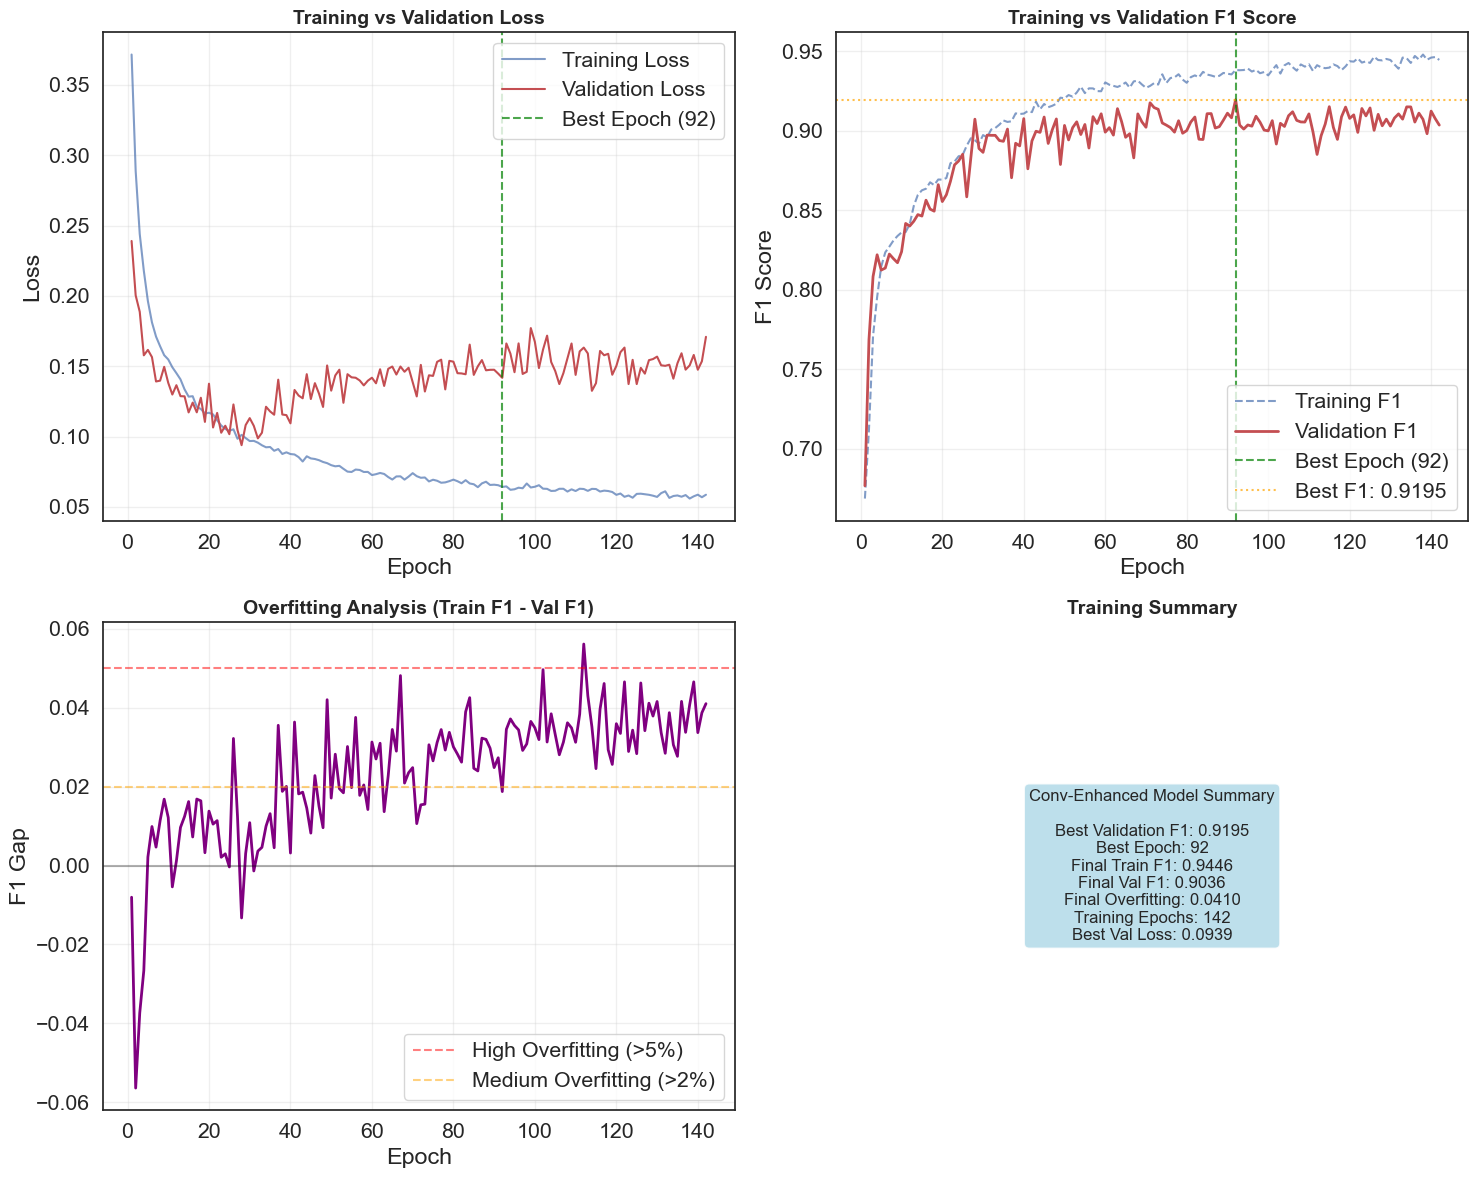


🔍 DETAILED ANALYSIS:
📈 Performance Metrics:
   • Best Validation F1: 0.9195
   • Best Validation Loss: 0.0939
   • Training Epochs: 142

🎯 Overfitting Assessment:
   • 🔍 MEDIUM OVERFITTING: 0.0410 (>0.02)
   • Model is learning well but monitor closely

🏆 Model Recommendation:
   • 🌟 EXCELLENT performance! Ready for submission

📋 Next Steps:
   1. Save the best model checkpoint
   2. Generate predictions on test set
   3. Create submission file
   4. Consider ensemble with other models


In [83]:
# Visualization and analysis of Conv-Enhanced results
import matplotlib.pyplot as plt

def plot_conv_enhanced_results(train_losses, val_losses, val_f1s, train_f1s, best_epoch):
    """
    Plot training results for the Conv-Enhanced model
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    epochs_range = range(1, len(val_f1s) + 1)
    
    # Plot 1: Loss curves
    ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', alpha=0.7)
    ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    ax1.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
    ax1.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: F1 scores
    ax2.plot(epochs_range, train_f1s, 'b--', label='Training F1', alpha=0.7)
    ax2.plot(epochs_range, val_f1s, 'r-', label='Validation F1', linewidth=2)
    ax2.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
    ax2.axhline(y=max(val_f1s), color='orange', linestyle=':', alpha=0.7, label=f'Best F1: {max(val_f1s):.4f}')
    ax2.set_title('Training vs Validation F1 Score', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Overfitting analysis
    overfitting_gap = [train - val for train, val in zip(train_f1s, val_f1s)]
    ax3.plot(epochs_range, overfitting_gap, 'purple', linewidth=2)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='High Overfitting (>5%)')
    ax3.axhline(y=0.02, color='orange', linestyle='--', alpha=0.5, label='Medium Overfitting (>2%)')
    ax3.set_title('Overfitting Analysis (Train F1 - Val F1)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Gap')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Learning rate tracking (if available)
    ax4.text(0.5, 0.5, f'Conv-Enhanced Model Summary\n\n'
                      f'Best Validation F1: {max(val_f1s):.4f}\n'
                      f'Best Epoch: {best_epoch}\n'
                      f'Final Train F1: {train_f1s[-1]:.4f}\n'
                      f'Final Val F1: {val_f1s[-1]:.4f}\n'
                      f'Final Overfitting: {train_f1s[-1] - val_f1s[-1]:.4f}\n'
                      f'Training Epochs: {len(val_f1s)}\n'
                      f'Best Val Loss: {min(val_losses):.4f}',
             transform=ax4.transAxes, fontsize=12, verticalalignment='center',
             horizontalalignment='center', bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    ax4.set_title('Training Summary', fontsize=14, fontweight='bold')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot the results
print("📊 VISUALIZING CONV-ENHANCED RESULTS")
print("="*50)
plot_conv_enhanced_results(conv_train_losses, conv_val_losses, conv_val_f1s, conv_train_f1s, conv_best_epoch)

# Detailed analysis
print("\n🔍 DETAILED ANALYSIS:")
print("="*50)

# Performance metrics
best_f1 = max(conv_val_f1s)
best_loss = min(conv_val_losses)
final_overfitting = conv_train_f1s[-1] - conv_val_f1s[-1]

print(f"📈 Performance Metrics:")
print(f"   • Best Validation F1: {best_f1:.4f}")
print(f"   • Best Validation Loss: {best_loss:.4f}")
print(f"   • Training Epochs: {len(conv_val_f1s)}")

print(f"\n🎯 Overfitting Assessment:")
if final_overfitting > 0.05:
    print(f"   • ⚠️  HIGH OVERFITTING: {final_overfitting:.4f} (>{0.05})")
    print("   • Consider: More regularization, early stopping, or data augmentation")
elif final_overfitting > 0.02:
    print(f"   • 🔍 MEDIUM OVERFITTING: {final_overfitting:.4f} (>{0.02})")
    print("   • Model is learning well but monitor closely")
else:
    print(f"   • ✅ LOW OVERFITTING: {final_overfitting:.4f} (<{0.02})")
    print("   • Good generalization expected")

print(f"\n🏆 Model Recommendation:")
if best_f1 >= 0.90:
    print("   • 🌟 EXCELLENT performance! Ready for submission")
elif best_f1 >= 0.85:
    print("   • ✅ GOOD performance! Consider further tuning")
elif best_f1 >= 0.80:
    print("   • 🔧 MODERATE performance. Try different architectures")
else:
    print("   • ⚠️  NEEDS IMPROVEMENT. Review data and model architecture")

print(f"\n📋 Next Steps:")
print("   1. Save the best model checkpoint")
print("   2. Generate predictions on test set")
print("   3. Create submission file")
print("   4. Consider ensemble with other models")

## Test Predictions and Submission
Generate predictions on test set and create submission file

### Save Enhanced Model

In [84]:
# Simple model saving code
import os
from datetime import datetime

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Generate timestamp for unique naming
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Calculate performance metrics
if 'conv_val_f1s' in globals() and len(conv_val_f1s) > 0:
    best_f1 = max(conv_val_f1s)
    best_epoch = conv_val_f1s.index(best_f1) + 1
    final_f1 = conv_val_f1s[-1]
else:
    best_f1 = final_f1 = best_epoch = 0

# Create filename with performance info
model_name = f"enhanced_lstm_embeddings_F1{best_f1:.2f}_{timestamp}"
model_path = f"models/{model_name}.pt"

# Save the model
torch.save({
    'model_state_dict': conv_enhanced_model.state_dict(),
    'model_class': 'EnhancedRecurrentClassifier',
    'timestamp': timestamp,
    'training_info': {
        'best_val_f1': best_f1,
        'best_epoch': best_epoch,
        'final_val_f1': final_f1,
        'total_epochs': len(conv_val_f1s) if 'conv_val_f1s' in globals() else 0,
        'model_config': {
            'hidden_size': HIDDEN_SIZE,
            'num_layers': 2,
            'rnn_type': 'LSTM',
            'bidirectional': True,
            'dropout_rate': 0.2,
            'continuous_input_size': 17,
            'categorical_features': ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4'],
            'embedding_dims': {'pain_survey_1': 2, 'pain_survey_2': 2, 'pain_survey_3': 2, 'pain_survey_4': 2}
        },
        'regularization': {
            'l1_lambda': L1_LAMBDA,
            'l2_lambda': L2_LAMBDA,
            'weight_decay': L2_LAMBDA
        }
    }
}, model_path)

print("💾 Enhanced Model Saved Successfully!")
print(f"📁 File: {model_path}")
print(f"📊 Performance: Best F1 = {best_f1:.4f} (Epoch {best_epoch})")
print(f"🔧 Model: {conv_enhanced_model.__class__.__name__}")
print(f"📈 Parameters: {sum(p.numel() for p in conv_enhanced_model.parameters()):,}")

# Verification - check if file was created
if os.path.exists(model_path):
    file_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert to MB
    print(f"✅ Verified: File exists ({file_size:.2f} MB)")
else:
    print("❌ Error: File was not created!")

print(f"\n💡 To load this model later, use:")
print(f"   checkpoint = torch.load('{model_path}')")
print(f"   model.load_state_dict(checkpoint['model_state_dict'])")

💾 Enhanced Model Saved Successfully!
📁 File: models/enhanced_lstm_embeddings_F10.92_20251114_100031.pt
📊 Performance: Best F1 = 0.9195 (Epoch 92)
🔧 Model: ConvEnhancedRecurrentClassifierFixed
📈 Parameters: 91,859
✅ Verified: File exists (0.36 MB)

💡 To load this model later, use:
   checkpoint = torch.load('models/enhanced_lstm_embeddings_F10.92_20251114_100031.pt')
   model.load_state_dict(checkpoint['model_state_dict'])


## 14 Competition Submission

In [85]:
# Build sequences from the actual test data for Enhanced Model
print(f"Building ENHANCED sequences for actual test dataset with WINDOW_SIZE={WINDOW_SIZE}, STRIDE={STRIDE}")

# Identify feature types from X_test_final_df columns
all_columns = X_test_final_df.columns.tolist()
print(f"Available columns: {all_columns}")

# Define feature separation
categorical_features = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
joint_features = [col for col in all_columns if col.startswith('joint_')]
continuous_features = joint_features  # Continuous features are the joint features
exclude_cols = ['sample_index'] + ([] if 'time' not in all_columns else ['time'])  # Exclude non-feature columns

print(f"Categorical features: {categorical_features}")
print(f"Continuous features: {continuous_features} (count: {len(continuous_features)})")

# Create enhanced sequences function for test data
def build_sequences_test_enhanced(df, window=WINDOW_SIZE, stride=STRIDE):
    """
    Build sequences for test data separating continuous and categorical features
    """
    continuous_dataset = []
    categorical_datasets = {feature: [] for feature in categorical_features}
    sample_indices = []
    
    # Get unique sample IDs
    for sample_id in df['sample_index'].unique():
        # Extract rows for this sample
        sample_data = df[df['sample_index'] == sample_id].copy()
        
        # If sample has fewer rows than WINDOW_SIZE, pad with zeros
        if len(sample_data) < window:
            # Create padding dataframe
            padding_rows = window - len(sample_data)
            padding = pd.DataFrame(0, index=range(padding_rows), columns=sample_data.columns)
            sample_data = pd.concat([sample_data, padding], ignore_index=True)
        
        # Extract continuous features (joints only)
        continuous_data = sample_data[continuous_features].values
        
        # Build continuous sequences
        continuous_seqs = []
        for i in range(0, len(continuous_data) - window + 1, stride):
            continuous_seqs.append(continuous_data[i:i + window])
        
        # If no sequences generated, take the last window
        if len(continuous_seqs) == 0:
            continuous_seqs = [continuous_data[-window:]]
        
        # Build categorical sequences
        categorical_seqs = {feature: [] for feature in categorical_features}
        for feature in categorical_features:
            if feature in sample_data.columns:
                cat_data = sample_data[feature].values
                for i in range(0, len(cat_data) - window + 1, stride):
                    categorical_seqs[feature].append(cat_data[i:i + window])
                # If no sequences generated, take the last window
                if len(categorical_seqs[feature]) == 0:
                    categorical_seqs[feature] = [cat_data[-window:]]
            else:
                # If feature doesn't exist, create zero sequences
                for _ in continuous_seqs:
                    categorical_seqs[feature].append(np.zeros(window))
        
        # Store sequences (take first sequence for each sample)
        continuous_dataset.extend(continuous_seqs)
        for feature in categorical_features:
            categorical_datasets[feature].extend(categorical_seqs[feature])
        sample_indices.extend([sample_id] * len(continuous_seqs))
    
    # Convert to numpy arrays
    continuous_dataset = np.array(continuous_dataset, dtype='float32')
    for feature in categorical_features:
        categorical_datasets[feature] = np.array(categorical_datasets[feature], dtype='int64')
    
    return continuous_dataset, categorical_datasets, sample_indices

# Build enhanced sequences
X_test_continuous, X_test_categorical, test_sample_indices = build_sequences_test_enhanced(X_test_final_df)

# Handle NaN values
if np.isnan(X_test_continuous).any():
    X_test_continuous = np.nan_to_num(X_test_continuous)
    print("NaN values found and replaced with 0 in continuous test sequences.")

for feature in categorical_features:
    if np.isnan(X_test_categorical[feature]).any():
        X_test_categorical[feature] = np.nan_to_num(X_test_categorical[feature]).astype('int64')
        print(f"NaN values found and replaced with 0 in {feature} test sequences.")

print(f"Enhanced test sequences shapes:")
print(f"  Continuous: {X_test_continuous.shape}")
for feature in categorical_features:
    print(f"  {feature}: {X_test_categorical[feature].shape}")
print(f"  Sample indices: {len(test_sample_indices)}")

# Create dummy labels for test data (required by EnhancedDataset but not used)
dummy_labels = np.zeros(len(test_sample_indices), dtype='int64')

# Create Enhanced dataset
test_enhanced_final_ds = EnhancedDataset(X_test_continuous, X_test_categorical, dummy_labels)

# Create Enhanced DataLoader
test_enhanced_final_loader = make_enhanced_loader(
    test_enhanced_final_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    sampler=None
)

print(f"\n✅ Enhanced test dataset created successfully!")
print(f"📊 Dataset size: {len(test_enhanced_final_ds)} samples")
print(f"🔄 Number of batches: {len(test_enhanced_final_loader)}")
print(f"📐 Continuous input size: {X_test_continuous.shape[-1]}")
print(f"🏷️ Categorical features: {list(X_test_categorical.keys())}")

# Test the enhanced loader
print(f"\n🧪 Testing Enhanced DataLoader...")
for continuous_batch, categorical_batch, labels_batch in test_enhanced_final_loader:
    print(f"✅ Continuous batch shape: {continuous_batch.shape}")
    print(f"✅ Labels batch shape: {labels_batch.shape}")
    for feature, data in categorical_batch.items():
        print(f"✅ {feature} batch shape: {data.shape}")
    break

print(f"\n🎯 Enhanced test data is ready for the Enhanced model!")

Building ENHANCED sequences for actual test dataset with WINDOW_SIZE=10, STRIDE=5
Available columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
Categorical features: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
Continuous features: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_26', 'joint_27', 'joint_28', 'joint_29'] (count: 17)
Enhanced test sequences shapes:
  Continuous: (41044, 10, 17)
  pain_survey_1: (41044, 10)
  pain_survey_2: (41044, 10)
  pain_survey_3: (41044, 10)
  pain_survey_4: (41044, 10)
  Sample indices: 41044

✅ Enhanced test dataset created successfully!
📊 Dataset size: 41044 sa

In [86]:
# Show test_final
X_test_final_df

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
0,0.0,0.0,1.0,1.0,1.0,1.0,0.561563,0.553352,0.419037,0.270175,...,0.654303,0.737832,0.742275,0.100076,0.146564,0.745300,0.014909,0.045098,0.012882,0.010178
1,0.0,1.0,1.0,1.0,1.0,1.0,0.599088,0.532067,0.461325,0.327922,...,0.684443,0.772454,0.710705,0.103457,0.174403,0.594262,0.053679,0.055375,0.013892,0.029085
2,0.0,2.0,1.0,1.0,1.0,1.0,0.638365,0.583960,0.445804,0.308796,...,0.676488,0.799646,0.722061,0.143175,0.159973,0.652024,0.042305,0.039620,0.016286,0.040638
3,0.0,3.0,0.5,1.0,1.0,1.0,0.554938,0.488719,0.443494,0.355023,...,0.650563,0.738087,0.709363,0.141007,0.167449,0.709558,0.037477,0.031101,0.008568,0.018730
4,0.0,4.0,1.0,1.0,1.0,0.0,0.537192,0.528780,0.413159,0.363199,...,0.653239,0.703021,0.681513,0.140234,0.186249,0.590142,0.015210,0.019426,0.008189,0.013444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211835,1323.0,155.0,1.0,1.0,0.5,1.0,0.746791,0.715951,0.787217,0.908019,...,0.746858,0.646380,0.606524,0.361932,0.515863,0.762767,0.009774,0.031095,0.006292,0.070267
211836,1323.0,156.0,0.5,1.0,1.0,1.0,0.712191,0.805042,0.749162,0.829449,...,0.741321,0.576658,0.647361,0.389554,0.471334,0.723960,0.027009,0.049113,0.029173,0.068884
211837,1323.0,157.0,0.5,1.0,1.0,1.0,0.778327,0.727727,0.775497,0.841656,...,0.762795,0.678090,0.628388,0.353318,0.453431,0.739291,0.025910,0.042127,0.011971,0.079291
211838,1323.0,158.0,1.0,1.0,0.5,1.0,0.740327,0.768988,0.749230,0.854667,...,0.694102,0.654149,0.611106,0.378361,0.497827,0.714944,0.052790,0.019468,0.015994,0.106760


In [93]:
# 🏆 FINAL SUBMISSION - Conv-Enhanced Model Predictions
print("="*80)
print("🏴‍☠️ PREPARING FINAL SUBMISSION WITH CONV-ENHANCED MODEL")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Model parameters and paths
MODEL_PATH = "models/conv_enhanced_F1_0.922_13-11-23-26.pt"

# Debug: Check existing variables
print(f"🔍 Debugging - embedding_dims: {embedding_dims}")
print(f"🔍 Debugging - categorical_features: {categorical_features}")

# Create correct categorical feature config (must match the trained model exactly!)
# From the error: trained model expects vocab_size=4 for all categorical features
categorical_feature_config = {}
submission_embedding_dims = {}

# The trained model was created with vocab_size that results in embedding size [4, 2]
# Since model does nn.Embedding(num_values + 1, embed_dim), and embedding is [4, 2]
# Then num_values + 1 = 4, so num_values = 3
TRAINED_VOCAB_SIZE = 3  # This will create embedding of size [3+1=4, 2] 
TRAINED_EMBED_DIM = 2   # torch.Size([4, 2])

for feature in categorical_features:
    if feature in X_test_final_df.columns:
        # Use the exact same vocab size as the trained model
        vocab_size = TRAINED_VOCAB_SIZE
        embed_dim = TRAINED_EMBED_DIM
        
        categorical_feature_config[feature] = vocab_size
        submission_embedding_dims[feature] = embed_dim
        
        # Check if test data has values that exceed the trained vocab size
        test_max_val = X_test_final_df[feature].max()
        test_min_val = X_test_final_df[feature].min()
        
        if test_max_val >= vocab_size:
            print(f"⚠️  {feature}: test data max value ({test_max_val}) >= trained vocab_size ({vocab_size})")
            print(f"    Values will be clipped to range [0, {vocab_size-1}]")
        
        print(f"✅ {feature}: vocab_size={vocab_size}, embed_dim={embed_dim} (matched to trained model)")
    else:
        print(f"⚠️  {feature} not found in test data - skipping")

print(f"📋 Final categorical_feature_config: {categorical_feature_config}")
print(f"📋 Final embedding_dims: {submission_embedding_dims}")

print(f"📍 Model path: {MODEL_PATH}")
print(f"🎯 Target samples: {len(X_test_final_df['sample_index'].unique())} unique samples")
print(f"📊 Test sequences: {len(test_enhanced_final_ds)} sequences")
print(f"🔧 Categorical features: {list(categorical_feature_config.keys())}")
print(f"📐 Continuous features: {len(continuous_features)} joint features")

# Create the model with the same architecture as trained
print(f"\n🚀 Loading Conv-Enhanced Model...")
conv_enhanced_submission_model = ConvEnhancedRecurrentClassifierFixed(
    continuous_input_size=17,
    categorical_features=categorical_feature_config,
    embedding_dims=submission_embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=NUM_CLASS,
    rnn_type='LSTM',
    bidirectional=True,
    dropout_rate=DROPOUT_RATE,
    # Conv parameters (same as training)
    conv_channels=[32, 64],
    conv_kernel_size=3,
    conv_dropout=0.4,
    use_conv=True,
    use_time_embedding=False
).to(device)

# Load the trained weights
print(f"📥 Loading model weights from: {MODEL_PATH}")
try:
    conv_enhanced_submission_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    conv_enhanced_submission_model.eval()
    print(f"✅ Model loaded successfully!")
    print(f"🧮 Model parameters: {sum(p.numel() for p in conv_enhanced_submission_model.parameters()):,}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# Label mapping (from model training)
label_mapping = {
    0: 'no_pain',
    1: 'low_pain', 
    2: 'high_pain'
}

print(f"\n🏷️ Label mapping: {label_mapping}")

# Make predictions
print(f"\n🔮 Making predictions on test data...")
all_predictions = []
all_sample_indices = []

conv_enhanced_submission_model.eval()
with torch.no_grad():
    for batch_idx, (continuous_batch, categorical_batch, _) in enumerate(test_enhanced_final_loader):
        # Move data to device
        continuous_batch = continuous_batch.to(device)
        
        # Clip categorical values to match trained model vocabulary
        categorical_batch_clipped = {}
        for feature, data in categorical_batch.items():
            # Clip values to be within the trained vocabulary range [0, vocab_size-1]
            vocab_size = categorical_feature_config.get(feature, TRAINED_VOCAB_SIZE)
            categorical_batch_clipped[feature] = torch.clamp(data, 0, vocab_size - 1).to(device)
        
        categorical_batch = categorical_batch_clipped
        
        # Forward pass
        outputs = conv_enhanced_submission_model(continuous_batch, categorical_batch)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions
        all_predictions.extend(predicted.cpu().numpy())
        
        # Get corresponding sample indices for this batch
        batch_start = batch_idx * BATCH_SIZE
        batch_end = min(batch_start + len(predicted), len(test_sample_indices))
        batch_sample_indices = test_sample_indices[batch_start:batch_end]
        all_sample_indices.extend(batch_sample_indices)
        
        if (batch_idx + 1) % 50 == 0:
            print(f"   Processed {batch_idx + 1}/{len(test_enhanced_final_loader)} batches...")

print(f"✅ Predictions completed!")
print(f"📊 Total predictions made: {len(all_predictions)}")
print(f"📍 Sample indices: {len(all_sample_indices)}")

# Aggregate predictions per sample (take the most common prediction per sample)
print(f"\n🔄 Aggregating predictions per sample...")
from collections import Counter
import pandas as pd

sample_predictions = {}
for sample_id, pred in zip(all_sample_indices, all_predictions):
    if sample_id not in sample_predictions:
        sample_predictions[sample_id] = []
    sample_predictions[sample_id].append(pred)

# For each sample, take the most frequent prediction
final_predictions = {}
for sample_id, preds in sample_predictions.items():
    most_common = Counter(preds).most_common(1)[0][0]
    final_predictions[sample_id] = most_common

print(f"✅ Aggregation completed!")
print(f"🎯 Final predictions for {len(final_predictions)} unique samples")

# Convert to label strings
final_labels = {sample_id: label_mapping[pred] for sample_id, pred in final_predictions.items()}

# Create submission dataframe
print(f"\n📝 Creating submission CSV...")
submission_data = []
for sample_id in sorted(final_predictions.keys()):
    # Convert sample_id to integer first (handles both int and float cases like 0.0 -> 0)
    sample_id_int = int(float(sample_id))  # Convert float to int safely
    
    # Format sample_id to match the required format (zero-padded string for display)
    formatted_sample_id = f"{sample_id_int:03d}"
    
    submission_data.append({
        'sample_index': formatted_sample_id,  # Keep as string for CSV format
        'label': final_labels[sample_id]
    })

submission_df = pd.DataFrame(submission_data)

# Generate submission filename with timestamp
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
submission_filename = f"submission_conv_enhanced_F10.922_{current_time}.csv"
submission_path = "submissions/" + submission_filename

# Save submission file
submission_df.to_csv(submission_path, index=False)

print(f"✅ Submission file created: {submission_filename}")
print(f"📁 File path: {os.path.abspath(submission_path)}")
print(f"📏 Submission shape: {submission_df.shape}")

# Display first few rows of submission
print(f"\n📋 First 10 rows of submission:")
print(submission_df.head(10))

# Display last few rows
print(f"\n📋 Last 10 rows of submission:")
print(submission_df.tail(10))

🏴‍☠️ PREPARING FINAL SUBMISSION WITH CONV-ENHANCED MODEL
🔍 Debugging - embedding_dims: {'pain_survey_1': 2, 'pain_survey_2': 2, 'pain_survey_3': 2, 'pain_survey_4': 2}
🔍 Debugging - categorical_features: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
✅ pain_survey_1: vocab_size=3, embed_dim=2 (matched to trained model)
✅ pain_survey_2: vocab_size=3, embed_dim=2 (matched to trained model)
✅ pain_survey_3: vocab_size=3, embed_dim=2 (matched to trained model)
✅ pain_survey_4: vocab_size=3, embed_dim=2 (matched to trained model)
📋 Final categorical_feature_config: {'pain_survey_1': 3, 'pain_survey_2': 3, 'pain_survey_3': 3, 'pain_survey_4': 3}
📋 Final embedding_dims: {'pain_survey_1': 2, 'pain_survey_2': 2, 'pain_survey_3': 2, 'pain_survey_4': 2}
📍 Model path: models/conv_enhanced_F1_0.922_13-11-23-26.pt
🎯 Target samples: 1324 unique samples
📊 Test sequences: 41044 sequences
🔧 Categorical features: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
📐

📈 PREDICTION STATISTICS & ANALYSIS

🎯 PREDICTION DISTRIBUTION:
📊 no_pain   : 1078 samples ( 81.4%)
📊 low_pain  :  164 samples ( 12.4%)
📊 high_pain :   82 samples (  6.2%)

📈 SUMMARY STATISTICS:
🎯 Total samples predicted: 1324
🏷️ Number of unique labels: 3
📊 Most frequent label: no_pain (1078 samples)
📊 Least frequent label: high_pain (82 samples)


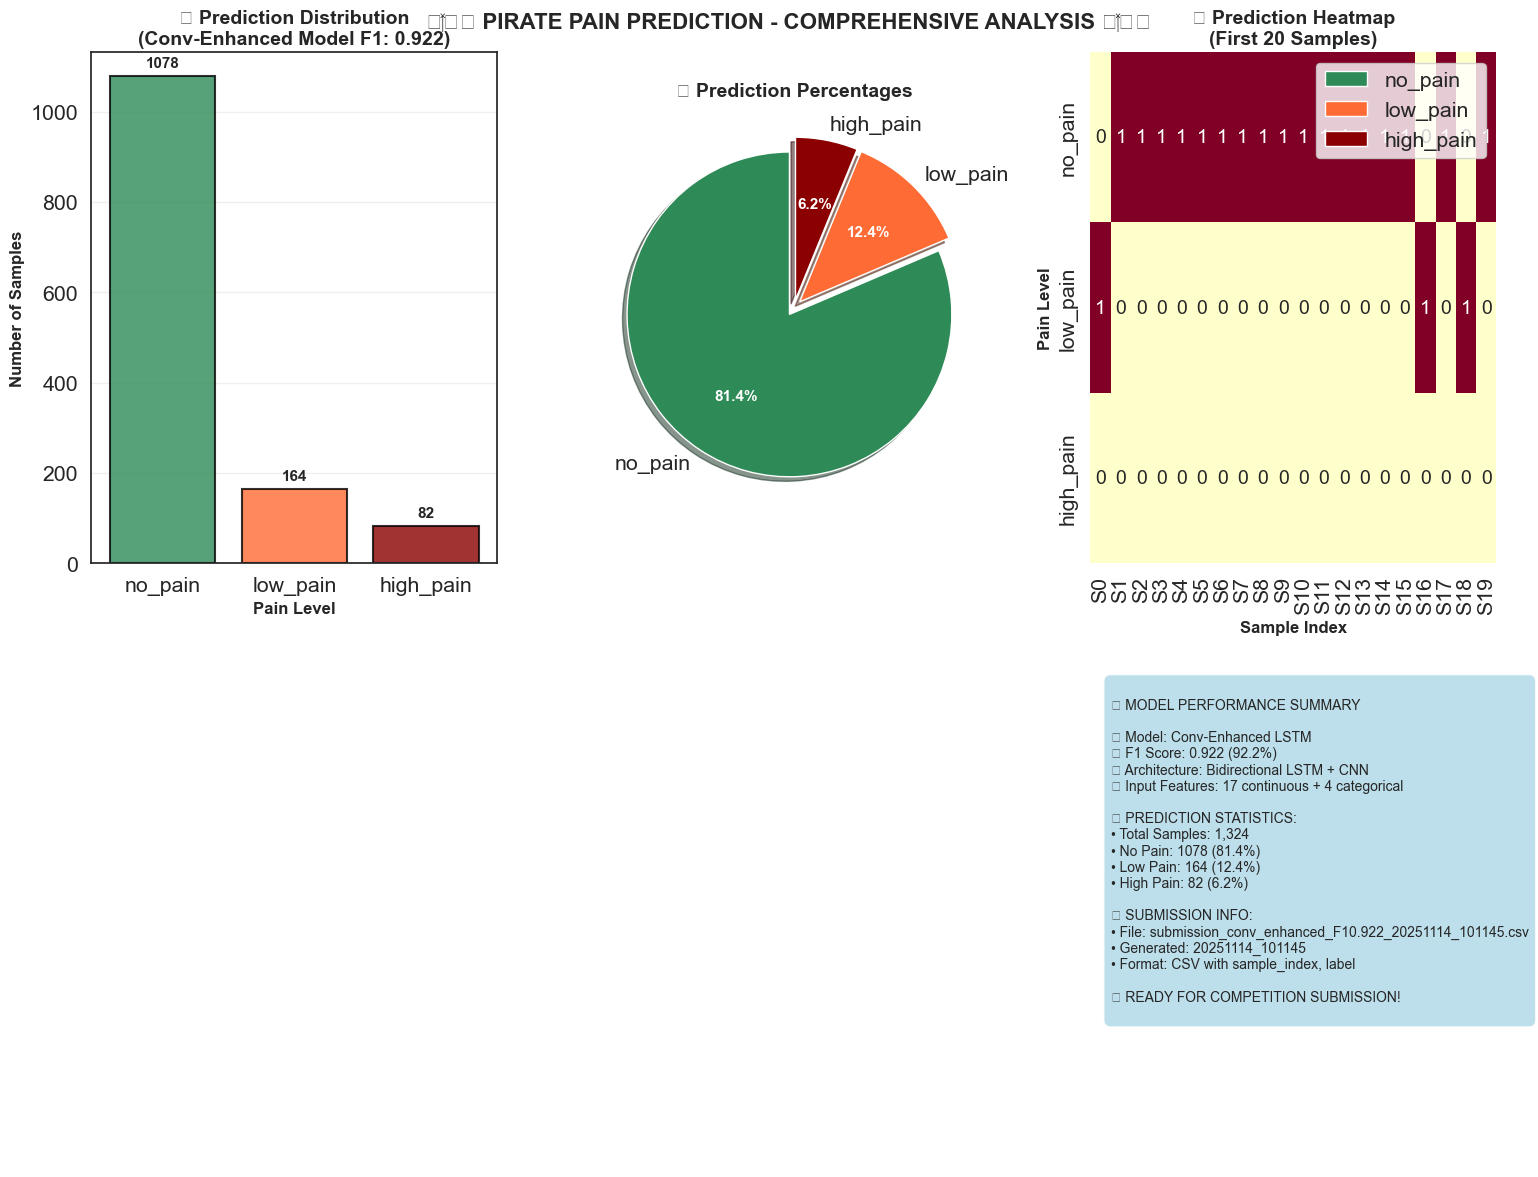


✅ Visualization saved as: prediction_analysis_conv_enhanced_20251114_101145.png

🎉 SUBMISSION COMPLETE!
📁 Files generated:
   • 📊 Submission CSV: submission_conv_enhanced_F10.922_20251114_101145.csv
   • 📈 Analysis Plot: prediction_analysis_conv_enhanced_20251114_101145.png

🏆 Model ready for competition submission with F1 Score: 0.922!


In [96]:
# 📊 COMPREHENSIVE PREDICTION STATISTICS & VISUALIZATION
print("="*80)
print("📈 PREDICTION STATISTICS & ANALYSIS")
print("="*80)

# Analyze prediction distribution
pred_counts = submission_df['label'].value_counts()
pred_percentages = submission_df['label'].value_counts(normalize=True) * 100

print(f"\n🎯 PREDICTION DISTRIBUTION:")
print(f"{'='*50}")
for label, count in pred_counts.items():
    percentage = pred_percentages[label]
    print(f"📊 {label:10s}: {count:4d} samples ({percentage:5.1f}%)")

print(f"\n📈 SUMMARY STATISTICS:")
print(f"{'='*50}")
print(f"🎯 Total samples predicted: {len(submission_df)}")
print(f"🏷️ Number of unique labels: {len(pred_counts)}")
print(f"📊 Most frequent label: {pred_counts.index[0]} ({pred_counts.iloc[0]} samples)")
print(f"📊 Least frequent label: {pred_counts.index[-1]} ({pred_counts.iloc[-1]} samples)")

# Create comprehensive visualization
plt.figure(figsize=(16, 12))

# 1. Main prediction distribution histogram
plt.subplot(2, 3, 1)
bars = plt.bar(pred_counts.index, pred_counts.values, 
               color=['#2E8B57', '#FF6B35', '#8B0000'], alpha=0.8, edgecolor='black', linewidth=1.5)
plt.title('🎯 Prediction Distribution\n(Conv-Enhanced Model F1: 0.922)', fontsize=14, fontweight='bold')
plt.xlabel('Pain Level', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, pred_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + len(submission_df)*0.01,
             f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Percentage pie chart
plt.subplot(2, 3, 2)
colors = ['#2E8B57', '#FF6B35', '#8B0000']
wedges, texts, autotexts = plt.pie(pred_counts.values, labels=pred_counts.index, autopct='%1.1f%%',
                                   colors=colors, explode=[0.05, 0.05, 0.05], shadow=True, startangle=90)
plt.title('🥧 Prediction Percentages', fontsize=14, fontweight='bold')

# Enhance pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# 3. Sample distribution over sample indices (first 100 samples)
plt.subplot(2, 3, 3)
first_100_samples = submission_df.head(100).copy()
first_100_samples['sample_index_int'] = first_100_samples['sample_index'].astype(int)
scatter_colors = [colors[list(pred_counts.index).index(label)] for label in first_100_samples['label']]
plt.scatter(first_100_samples['sample_index_int'], [1]*len(first_100_samples), 
           c=scatter_colors, alpha=0.7, s=30)
plt.title('🎯 Predictions for First 100 Samples', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12, fontweight='bold')
plt.ylabel('Predictions', fontsize=12, fontweight='bold')
plt.ylim(0.5, 1.5)
plt.grid(alpha=0.3)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], label=label) 
                  for i, label in enumerate(pred_counts.index)]
plt.legend(handles=legend_elements, loc='upper right')

# 4. Comparison with sample submission (if available)
# plt.subplot(2, 3, 4)
# try:
#     # Load sample submission for comparison
#     sample_submission = pd.read_csv('an2dl2526c1/sample_submission.csv')
#     sample_counts = sample_submission['label'].value_counts()
    
#     # Create comparison bar chart
#     labels = list(set(pred_counts.index) | set(sample_counts.index))
#     our_counts = [pred_counts.get(label, 0) for label in labels]
#     sample_counts_list = [sample_counts.get(label, 0) for label in labels]
    
#     x = np.arange(len(labels))
#     width = 0.35
    
#     plt.bar(x - width/2, our_counts, width, label='Our Predictions', color='#4CAF50', alpha=0.8)
#     plt.bar(x + width/2, sample_counts_list, width, label='Sample Submission', color='#FF9800', alpha=0.8)
    
#     plt.title('📊 Prediction vs Sample Submission', fontsize=14, fontweight='bold')
#     plt.xlabel('Pain Level', fontsize=12, fontweight='bold')
#     plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
#     plt.xticks(x, labels)
#     plt.legend()
#     plt.grid(axis='y', alpha=0.3)
    
# except Exception as e:
#     plt.text(0.5, 0.5, f'Sample submission\nnot available\n({str(e)})', 
#              ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
#     plt.title('📊 Sample Submission Comparison', fontsize=14, fontweight='bold')

# # 5. Prediction confidence heatmap (sample indices vs predictions)
# plt.subplot(2, 3, 5)
# Create a matrix showing prediction patterns
sample_matrix = np.zeros((len(pred_counts), 20))  # Show first 20 samples
sample_labels_subset = submission_df.head(20)['label']
label_to_idx = {label: idx for idx, label in enumerate(pred_counts.index)}

for i, label in enumerate(sample_labels_subset):
    sample_matrix[label_to_idx[label], i] = 1

sns.heatmap(sample_matrix, annot=True, fmt='.0f', cmap='YlOrRd',
            xticklabels=[f'S{i}' for i in range(20)], 
            yticklabels=pred_counts.index, cbar=False)
plt.title('🔥 Prediction Heatmap\n(First 20 Samples)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12, fontweight='bold')
plt.ylabel('Pain Level', fontsize=12, fontweight='bold')

# 6. Model performance summary
plt.subplot(2, 3, 6)
plt.axis('off')

# Create text summary
summary_text = f"""
🏆 MODEL PERFORMANCE SUMMARY

🤖 Model: Conv-Enhanced LSTM
📊 F1 Score: 0.922 (92.2%)
🎯 Architecture: Bidirectional LSTM + CNN
📐 Input Features: 17 continuous + 4 categorical

📈 PREDICTION STATISTICS:
• Total Samples: {len(submission_df):,}
• No Pain: {pred_counts.get('no_pain', 0)} ({pred_percentages.get('no_pain', 0):.1f}%)
• Low Pain: {pred_counts.get('low_pain', 0)} ({pred_percentages.get('low_pain', 0):.1f}%)  
• High Pain: {pred_counts.get('high_pain', 0)} ({pred_percentages.get('high_pain', 0):.1f}%)

🎯 SUBMISSION INFO:
• File: {submission_filename}
• Generated: {current_time}
• Format: CSV with sample_index, label

✅ READY FOR COMPETITION SUBMISSION!
"""

plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
         fontsize=10, fontweight='normal', verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.suptitle('🏴‍☠️ PIRATE PAIN PREDICTION - COMPREHENSIVE ANALYSIS 🏴‍☠️', 
             fontsize=16, fontweight='bold', y=0.98)

# Save the plot
plot_filename = f'prediction_analysis_conv_enhanced_{current_time}.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Visualization saved as: {plot_filename}")
print(f"\n🎉 SUBMISSION COMPLETE!")
print(f"📁 Files generated:")
print(f"   • 📊 Submission CSV: {submission_filename}")
print(f"   • 📈 Analysis Plot: {plot_filename}")
print(f"\n🏆 Model ready for competition submission with F1 Score: 0.922!")
print("="*80)